## __Plato Notebook 3: Slab pull optimisation__

Thomas Schouten, Whitney Behr, Edward Clennett, Thorsten Becker


#### __0. Prepare Python__

First, we load the required packages.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from collections import defaultdict
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.spatial import cKDTree
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from plato.optimisation import Optimisation
from plato.plate_torques import PlateTorques
from plato.plot import PlotReconstruction
from plato.slabs import Slabs
from plato.grids import Grids

#### __1. Set up the PlateTorques object__

The below cell loads a `PlateTorques` object for the Müller et al. (2016) reconstruction by providing the ages of interest and the relevant reconstruction files from the sample data folder.

In [2]:
# Set parameters
SAMPLE_SLABS = False  # Whether or not to sample seafloor ages at slabs
COMPUTE_VELOCITIES = False  # Whether or not to compute velocities

# Plate reconstruction
reconstruction_name = "Muller2016" 

# Set reconstruction ages
ages = np.arange(0, 201, 1)

# Set ages for the correlation
max_ages = np.arange(0, 91, 1)

# Plates of interest
plateIDs = [901, 902, 903, 904, 909, 911, 918, 926]
plate_names = ["Pacific", "Farallon", "Juan de Fuca", "Aluk", "Cocos", "Nazca", "Kula", "Izanagi"]

# Load excel file with settings
settings_file = os.path.join(os.getcwd(), "settings.xlsx")

# Set directory with sample data
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "sample_data", "M2016"))

# Set directory with supplementary data
suppl_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "supplementary_data"))

# Set directory to save the results
results_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "output_notebooks", "04b-Slab_pull_optimisation"))

# Set directory to load calculated torques
load_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "exports_notebooks", "03-Uncertainty_analysis"))

# Set directory to save the figures
figs_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "figures_notebooks", "04c-Slab_pull_optimisation"))

# Load seafloor ages
seafloor_age_grids = {}; continental_grids = {}
for age in ages:
    file_path = os.path.join(data_dir, "seafloor_age_grids", f"M2016_SeafloorAgeGrid_{age}Ma.nc")
    if os.path.exists(file_path):
        seafloor_age_grids[age] = xr.open_dataset(file_path)
    else:
        seafloor_age_grids[age] = None

# Plotting parameters
cm2in = 0.3937008
fig_width = 18*cm2in*2; fig_height_graphs = 8*cm2in*2; fig_height_maps = 10.5*cm2in*2
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Arial"
title_fontsize = 18
plot_times = [45, 60, 75, 90]
projection = ccrs.Robinson(central_longitude = 160) 
annotations = ["a", "b", "c", "d"]

In [3]:
# Load reveal
reveal = xr.open_dataset(os.path.join(suppl_dir, "REVEAL_anomaly.nc"))

# Load modern slab data
modern_slab_data = pd.read_excel(os.path.join(data_dir, "present_day_sediments", "Modern_slab_data.xlsx"))

# Load GlobSed
globsed = xr.open_dataset(os.path.join(data_dir, "present_day_sediments", "GlobSed-v3.nc"))

In [4]:
# Set up PlateTorques objects
M2016 = PlateTorques(
    reconstruction_name = "Muller2016",
    ages = [0],
    files_dir = results_dir,
    rotation_file = os.path.join(data_dir, "gplates_files", "M2016_rotations_Lr-Hb.rot"),
    topology_file = os.path.join(data_dir, "gplates_files", "M2016_topologies.gpml"),
    polygon_file = os.path.join(data_dir, "gplates_files",  "M2016_static_polygons.gpml"),
    seafloor_age_grids = seafloor_age_grids,
)

Calculating RMS velocities: 100%|██████████| 1/1 [00:00<00:00, 11915.64it/s]


In [5]:
M2016_slabs = Slabs(
    reconstruction_name = "Muller2016",
    ages = ages,
    cases_file = settings_file,
    cases_sheet = "4 - Slab pull optimisation",
    files_dir = results_dir,
    rotation_file = os.path.join(data_dir, "gplates_files", "M2016_rotations_Lr-Hb.rot"),
    topology_file = os.path.join(data_dir, "gplates_files", "M2016_topologies.gpml"),
    polygon_file = os.path.join(data_dir, "gplates_files",  "M2016_static_polygons.gpml"),
)

Loading slab data: 100%|██████████| 201/201 [00:12<00:00, 16.25it/s]


In [6]:
if SAMPLE_SLABS:
    M2016_seafloor_grids = Grids(
        reconstruction_name = "Muller2016",
        ages = np.arange(91, 156),
        files_dir = results_dir,
        rotation_file = os.path.join(data_dir, "gplates_files", "M2016_rotations_Lr-Hb.rot"),
        topology_file = os.path.join(data_dir, "gplates_files", "M2016_topologies.gpml"),
        polygon_file = os.path.join(data_dir, "gplates_files",  "M2016_static_polygons.gpml"),
        seafloor_age_grids = seafloor_age_grids,
    )

#### __2. Sampling__

The below cell calls the `sample_slab_seafloor_ages` method of the `PlateTorques` object to sample seafloor ages at subduction zones and grid points.

In [7]:
if SAMPLE_SLABS:
    # Sample seafloor ages at slabs
    M2016_slabs.sample_slab_seafloor_ages(ages = np.arange(91, 156), grids = M2016_seafloor_grids.seafloor_age)

In [8]:
if SAMPLE_SLABS:
    M2016_slabs.calculate_slab_pull_force(ages = np.arange(91, 156))

#### __3. Calculation of slab flux__

The below cells initialise an `Optimisation` object, that contains methods to optimise the free parameters in the plate torque balance, using the `PlateTorques` object.

Then

In [9]:
if COMPUTE_VELOCITIES:
    M2016_slabs.calculate_velocities()

In [10]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two sets of points on Earth.

    :param lat1:    Latitude of the first point in degrees.
    :type lat1:     float
    :param lon1:    Longitude of the first point in degrees.
    :type lon1:     float
    :param lat2:    Latitude of the second point in degrees.
    :type lat2:     float
    :param lon2:    Longitude of the second point in degrees.
    :type lon2:     float

    :return:        The Haversine distance between the two points.
    :rtype:         float
    """
    # Convert latitude and longitude from degrees to radians
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return c

def latlon_to_xyz(lat, lon):
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    x = np.cos(lat_rad) * np.cos(lon_rad)
    y = np.cos(lat_rad) * np.sin(lon_rad)
    z = np.sin(lat_rad)
    return np.vstack((x, y, z)).T

In [11]:
# Sample modern slab data at slab locations
for age in max_ages:
    lons = np.where(modern_slab_data.lon > 180, modern_slab_data.lon - 360, modern_slab_data.lon)
    for i, _ in enumerate(M2016_slabs.data[age]["opt2"].lat):
        distance_to_segments = haversine(
            M2016_slabs.data[age]["opt2"].loc[i, "lat"],
            M2016_slabs.data[age]["opt2"].loc[i, "lon"],
            modern_slab_data.lat,
            lons
        )
        for col in modern_slab_data.columns:
            if col in ["trench_section", "lat", "lon"]:
                continue

            M2016_slabs.data[age]["opt2"].loc[i, col] = modern_slab_data[col][distance_to_segments.idxmin()]

            if col in ["sediment_thickness"]:
                M2016_slabs.data[age]["opt2"].loc[i, col] *= 1e3
        
M2016_slabs.options["opt2"]["Active margin sediments"] = True

In [12]:
# Columns of interest
columns_of_interest = [
    "slab_lithospheric_thickness",
    "sediment_thickness",
    "slab_flux",
    "material_subduction_rate",
    # "wedge_width",
    "arc_crustal_thickness"
]

# Initialise lists to store coefficients
coefficients = {col: [] for col in columns_of_interest}
r_squareds = []

In [13]:
# Calculate slab flux for each age
for age in max_ages:
    # Initialise lists to store slab flux data
    lats, lons, fluxes = [], [], []

    # Calculate slab flux
    for _age in np.arange(age, age+100, 1):
        slab_data = M2016_slabs.data[_age]["opt2"].copy(deep=True)
        slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs)]

        slab_flux = (
            (slab_data.slab_lithospheric_thickness + slab_data.slab_crustal_thickness) *
            slab_data.convergence_velocity_mag / 1e2 *
            slab_data.trench_segment_length * 1e6
        )

        lats.extend(slab_data.lat.values)
        lons.extend(slab_data.lon.values)
        fluxes.extend(slab_flux)

    lats = np.array(lats)
    lons = np.array(lons)
    fluxes = np.array(fluxes)

    slab_data = M2016_slabs.data[age]["opt2"].copy(deep=True)
    slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs)]

    xyz_A = latlon_to_xyz(slab_data.lat, slab_data.lon)
    xyz_B = latlon_to_xyz(lats, lons)

    tree_B = cKDTree(xyz_B)

    max_angle_rad = np.radians(20)
    max_chord_dist = 2 * np.sin(max_angle_rad / 2)

    neighbors_idx = tree_B.query_ball_point(xyz_A, r=max_chord_dist)

    slab_data["slab_flux"] = np.array([
        fluxes[idx].sum() if len(idx) > 0 else 0
        for idx in neighbors_idx
    ])

    M2016_slabs.data[age]["opt2"]["slab_flux"] = slab_data["slab_flux"]

In [14]:
# Save all data if the torques have been computed
# if SAMPLE_SLABS:
M2016_slabs.save()

Saving Slabs: 100%|██████████| 201/201 [00:18<00:00, 10.72it/s]


In [15]:
# Compute trench length, number of plates, and max column values over time
total_trench_lengths = []
plate_counts = []
max_vals = {col: 0 for col in columns_of_interest}

for age in max_ages:
    slab_data = M2016_slabs.data[age]["opt2"].copy(deep=True)
    
    plate_set = set(plateIDs)  # Convert once per loop for performance

    if age < 36:
        excluded = {501}
    elif age < 46:
        excluded = {501, 608}
    elif age < 56:
        excluded = {608}
    else:
        excluded = {608, 901}

    filtered_ids = plate_set - excluded
    slab_data = slab_data[slab_data.lower_plateID.isin(filtered_ids)]

    # Record trench length and number of plates
    total_trench_lengths.append(slab_data.trench_segment_length.dropna().sum())
    plate_counts.append(slab_data.lower_plateID.nunique())

    # Update global max values
    for col in columns_of_interest:
        col_max = slab_data[col].max(skipna=True)
        if pd.notna(col_max) and col_max > max_vals[col]:
            max_vals[col] = col_max

In [16]:
# Load plate areas
plate_areas = pd.read_csv(os.path.join(load_dir, "Lr-Hb_plate_areas_ref.csv"))

# Convert plateID list to strings for consistent matching with column names
plate_set = set(str(pid) for pid in plateIDs)

# Function to determine which plateIDs to exclude at a given age
def get_excluded(age):
    if age < 36:
        return {"501"}
    elif age < 46:
        return {"501", "608"}
    elif age < 56:
        return {"608"}
    else:
        return {"608", "901"}

# Initialize list to store summed values
summed_plate_areas = []

# Iterate over each row (age)
for _, row in plate_areas.iterrows():
    age = row["Age"]

    if age > max_ages[-1]:
        continue

    excluded = get_excluded(age)
    filtered_ids = plate_set - excluded

    # Make sure columns exist in DataFrame
    valid_cols = [pid for pid in filtered_ids if pid in row.index]

    # Sum across the selected plate columns
    total_area = row[valid_cols].sum(skipna=True)
    summed_plate_areas.append(total_area)

summed_plate_areas = np.array(summed_plate_areas)

In [17]:
# Set whether to use a linear regression or a ridge regression (with 5-fold cross-validation)
USE_RIDGE = True

# Step 1: Collect all column values across all ages (for normalisation)
all_column_values = {col: [] for col in columns_of_interest}

for age in max_ages:
    slab_data = M2016_slabs.data[age]["opt2"].copy(deep=True)
    slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs)]
    slab_data = slab_data[columns_of_interest].dropna()
    for col in columns_of_interest:
        all_column_values[col].extend(slab_data[col].values)

# Step 3: Initialize results dictionary
results = {
    use_window: {
        "coefficients": {col: [] for col in columns_of_interest},
        "r_squared": [],
        "all_normalised_data": []  # Store data for correlation
    } for use_window in [True, False]
}

# Step 4: Regression loop
for use_window in [True, False]:
    for age in max_ages:
        x_multi_list = []
        y_multi_list = []
        all_slab_data = []
        weights = []

        age_range = np.arange(0, age + 1) if use_window else [age]

        for current_age in age_range:
            slab_data = M2016_slabs.data[current_age]["opt2"].copy(deep=True)
            slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs)]
            slab_data = slab_data.dropna(axis=0, how='all')
            slab_data = slab_data.dropna(subset=columns_of_interest + ["slab_pull_constant", "trench_segment_length"])

            for col in columns_of_interest:
                slab_data[col] /= max_vals[col]

            if age == 0 and use_window == False:
                _slab_data = slab_data[columns_of_interest]

            all_slab_data.append(slab_data[columns_of_interest])

            weights.extend(slab_data.trench_segment_length.values)
            features = slab_data[columns_of_interest].values
            targets = (1-slab_data.slab_pull_constant.values)

            x_multi_list.append(features)
            y_multi_list.append(targets)

        x_multi = np.vstack(x_multi_list)
        y_multi = np.concatenate(y_multi_list)

        if USE_RIDGE:
            model = RidgeCV(cv=5)
        else:
            model = LinearRegression()
            
        model.fit(x_multi, y_multi, sample_weight=weights)

        r2 = model.score(x_multi, y_multi)

        for col, coef in zip(columns_of_interest, model.coef_):
            results[use_window]["coefficients"][col].append(coef)

        results[use_window]["r_squared"].append(r2)

        # Save all normalised values for correlation analysis
        if all_slab_data:
            all_normalised_df = pd.concat(all_slab_data, ignore_index=True)
            results[use_window]["all_normalised_data"].append(all_normalised_df)

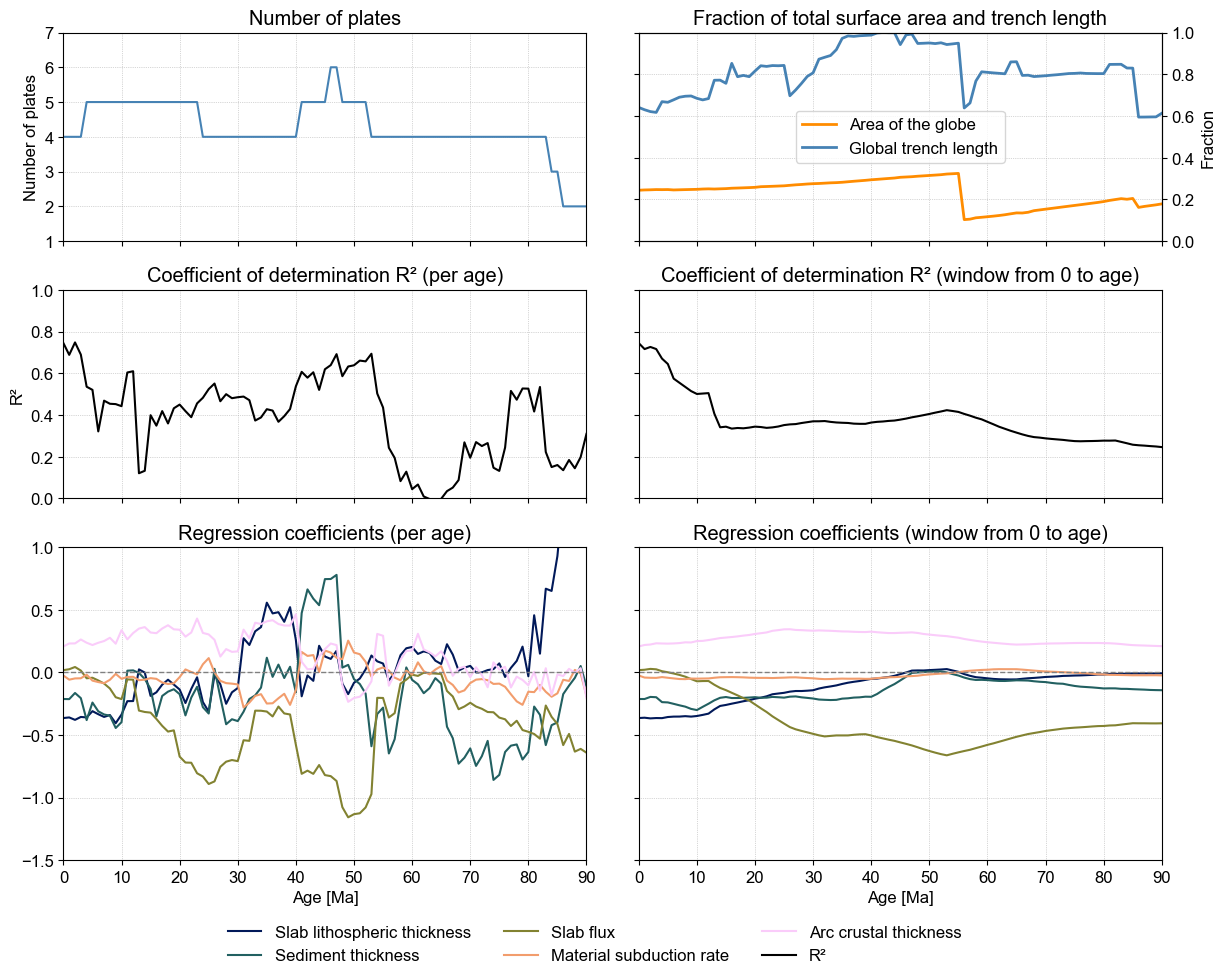

In [33]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os

# Assume variables like max_ages, plate_counts, summed_plate_areas, total_trench_lengths,
# results, columns_of_interest, figs_dir, fig_width, fig_height_maps are already defined

colours = plt.get_cmap("cmc.batlow")(np.linspace(0, 1, len(columns_of_interest)))

fig = plt.figure(figsize=(fig_width, fig_height_maps * 1.3))  # Make figure taller to fit 3 rows
gs = gridspec.GridSpec(3, 2, wspace=0.1, hspace=0.2, height_ratios=[1, 1, 1.5])  # Adjust height ratios for better spacing

# top-left: number of plates and total plate area fraction
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(max_ages, plate_counts, color="steelblue", lw=1.5)
ax0.set_ylim(1, 7)
ax0.set_title("Number of plates")
ax0.set_ylabel("Number of plates")
ax0.grid(True, linestyle=":", linewidth=0.5)

# top-right: fraction of total surface area and trench length on single right y-axis
ax1 = fig.add_subplot(gs[0, 1])

# normalize trench length by max trench length for fraction scaling
plate_area_frac = summed_plate_areas / (6371e3**2 * np.pi * 4)
trench_length_frac = total_trench_lengths / np.max(total_trench_lengths)

ax1.plot(max_ages, plate_area_frac, color="darkorange", lw=2, label="Area of the globe")
ax1.plot(max_ages, trench_length_frac, color="steelblue", lw=2, label="Global trench length")
ax1.set_title("Fraction of total surface area and trench length")
ax1.set_ylim(0, 1)
ax1.grid(True, linestyle=":", linewidth=0.5)
ax1.set_xlim(max_ages[0], max_ages[-1])
ax1.set_ylabel("")
ax1.yaxis.set_tick_params(labelleft=False)

ax1b = ax1.twinx()
ax1b.set_ylim(0, 1)
ax1b.set_ylabel("Fraction")
ax1b.yaxis.label.set_color("black")
ax1b.tick_params(axis='y', colors='black')
ax1b.grid(False)

ax1.legend()

# dictionary to hold axes for R² and coefficients plots (2 cols x 2 rows)
axes_dict = {
    False: {"r2": fig.add_subplot(gs[1, 0]), "coef": fig.add_subplot(gs[2, 0])},
    True: {"r2": fig.add_subplot(gs[1, 1]), "coef": fig.add_subplot(gs[2, 1])},
}

# plot R² and regression coefficients for both no-window and window cases
for use_window in [False, True]:
    ax_r2 = axes_dict[use_window]["r2"]
    ax_r2.plot(
        max_ages,
        results[use_window]["r_squared"],
        color="black",
        linestyle="-",
        label="R²",
        lw=1.5,
    )
    ax_r2.set_title(f"Coefficient of determination R² ({'per age' if not use_window else 'window from 0 to age'})")
    ax_r2.set_ylim(0, 1)
    ax_r2.set_ylabel("R²")
    ax_r2.grid(True, linestyle=":", linewidth=0.5)
    ax_r2.set_xlim(max_ages[0], max_ages[-1])
    ax_r2.set_xticks(np.arange(max_ages[0], max_ages[-1] + 1, 10))
    ax_r2.set_xlabel("")
    ax_r2.set_xticklabels([])

    ax_coef = axes_dict[use_window]["coef"]
    for col in columns_of_interest:
        ax_coef.plot(
            max_ages,
            results[use_window]["coefficients"][col],
            label=col.replace("_", " ").capitalize(),
            color=colours[columns_of_interest.index(col)],
            lw=1.5,
        )
    ax_coef.set_title(f"Regression coefficients ({'per age' if not use_window else 'window from 0 to age'})")
    ax_coef.set_xlabel("Age [Ma]")
    ax_coef.axhline(0, color="gray", linestyle="--", lw=1)
    ax_coef.set_ylim(-1.5, 1)
    ax_coef.grid(True, linestyle=":", linewidth=0.5)
    ax_coef.set_xlim(max_ages[0], max_ages[-1])
    ax_coef.set_xticks(np.arange(max_ages[0], max_ages[-1] + 1, 10))

# remove y-labels and ticklabels on right column plots
axes_dict[True]["r2"].set_ylabel("")
axes_dict[True]["coef"].set_ylabel("")
axes_dict[True]["r2"].yaxis.set_tick_params(labelleft=False)
axes_dict[True]["coef"].yaxis.set_tick_params(labelleft=False)

# remove x-labels on top two rows (already done for R² plots)
for ax in [ax0, ax1]:
    ax.set_xlabel("")
    ax.set_xticklabels([])

# set xlims consistently for top row as well
ax0.set_xlim(max_ages[0], max_ages[-1])
ax1.set_xlim(max_ages[0], max_ages[-1])

# add shared legend for coefficients and R² below bottom row plots
handles_coef, labels_coef = axes_dict[False]["coef"].get_legend_handles_labels()
handles_r2, labels_r2 = axes_dict[False]["r2"].get_legend_handles_labels()
fig.legend(
    handles_coef + handles_r2,
    labels_coef + labels_r2,
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, -0.0),
)

fig.savefig(os.path.join(figs_dir, "Regression_coefficients_and_R2.png"), bbox_inches='tight', dpi=300)
plt.show()

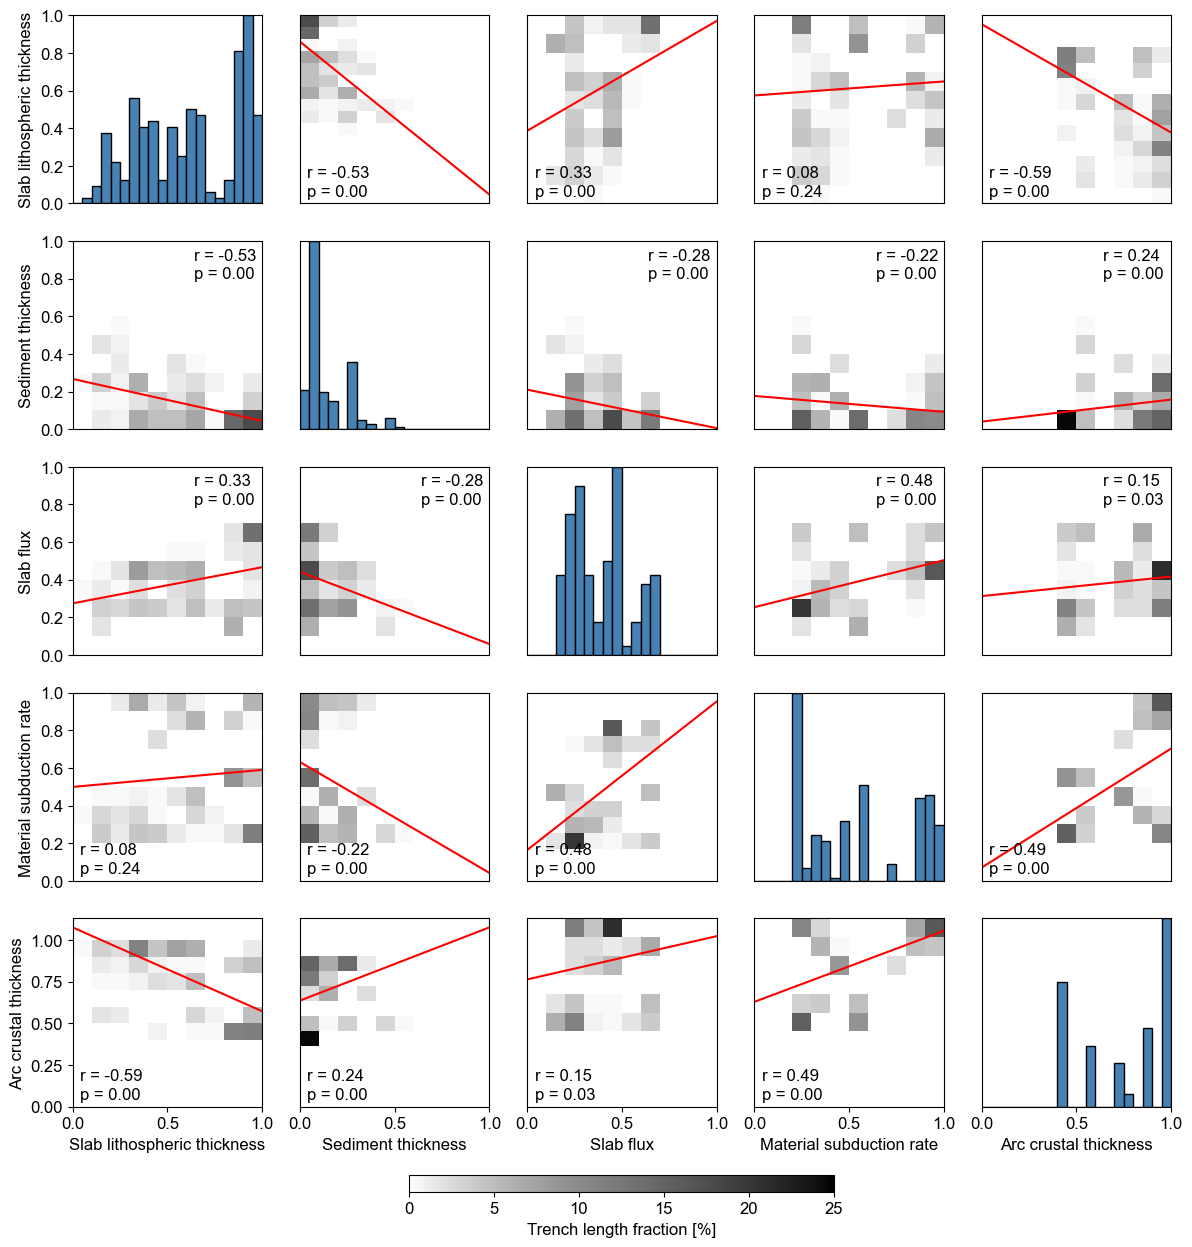

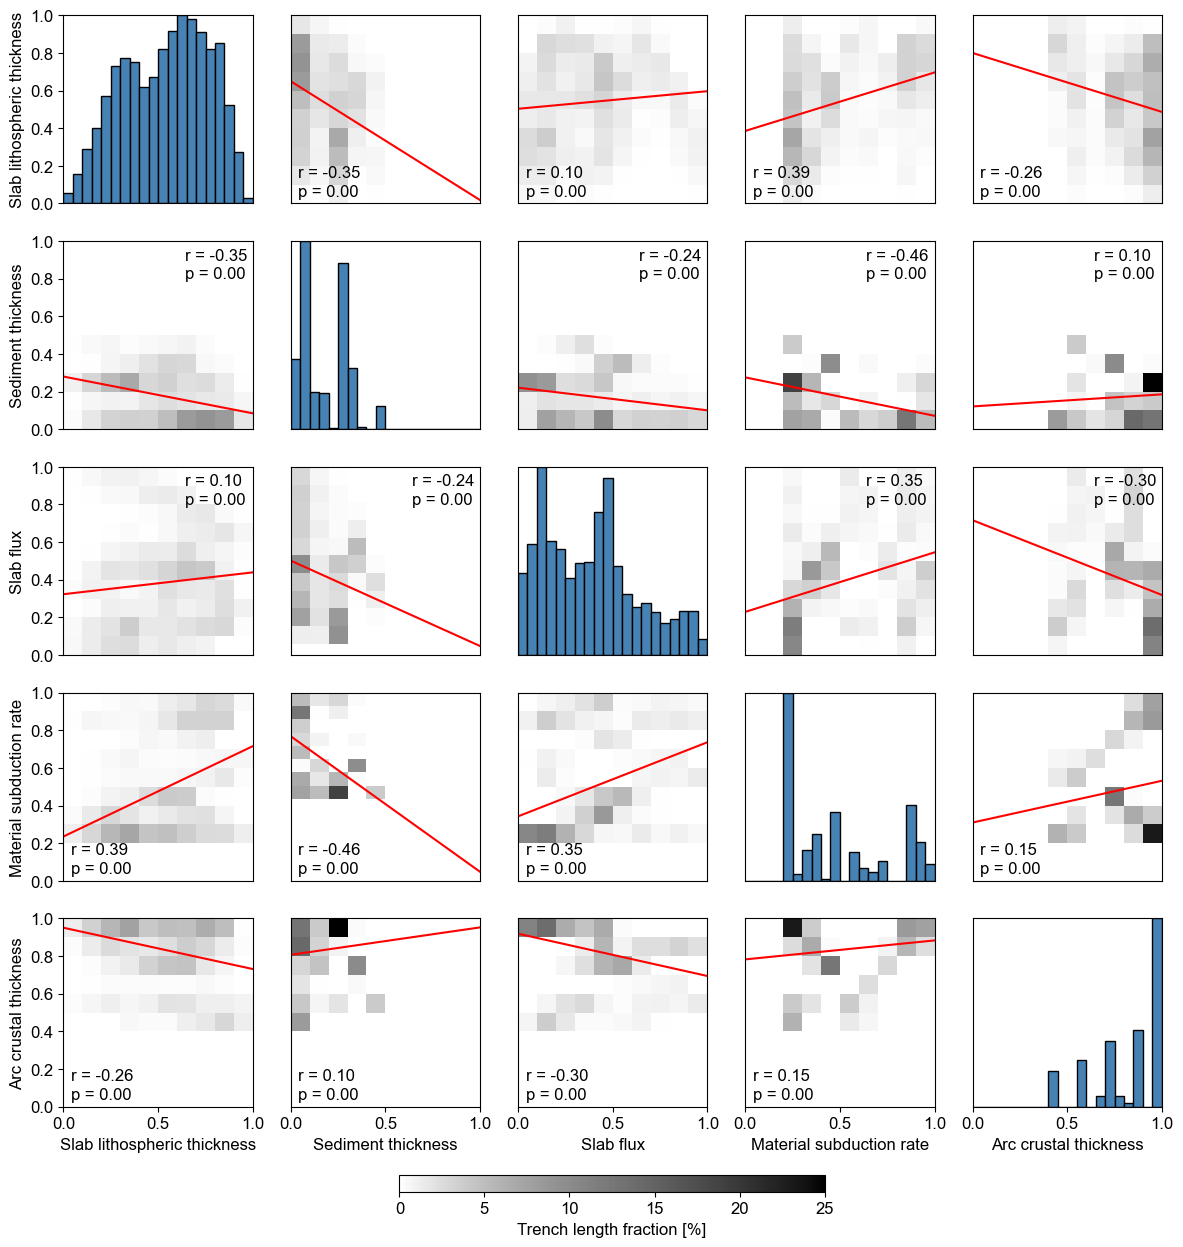

In [19]:
def format_label(label):
    return label.replace("_", " ").capitalize()

for ages in [0, "all"]:
    if ages == 0:
        data = _slab_data
    else:
        data = pd.concat(results[False]["all_normalised_data"], ignore_index=True)

    n = len(columns_of_interest)
    fixed_bins = np.linspace(0, 1, 21)
    
    # Precompute global max for consistent color scale
    all_counts = []
    for i in range(n):
        for j in range(n):
            if i != j:
                x = data[columns_of_interest[j]]
                y = data[columns_of_interest[i]]
                counts, _, _ = np.histogram2d(x, y, bins=[10, 10], range=[[0, 1], [0, 1]])
                all_counts.append(counts)

    global_vmax = np.max([c.max() for c in all_counts])

    # Begin plotting
    fig, axes = plt.subplots(n, n, figsize=(fig_width, fig_width))
    plt.subplots_adjust(hspace=0.2, wspace=0.2)

    # To store last 2D histogram for colorbar
    quadmesh_for_colorbar = None

    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            x = data[columns_of_interest[j]]
            y = data[columns_of_interest[i]]

            if i == j:
                counts, bins = np.histogram(x, bins=fixed_bins)
                counts = counts / counts.max()
                ax.bar(bins[:-1], counts, width=np.diff(bins), color='steelblue', edgecolor='black', align='edge')
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
            else:
                # 2D histogram with consistent color scale
                # Compute histogram counts
                counts, xedges, yedges = np.histogram2d(x, y, bins=[10, 10], range=[[0,1],[0,1]])

                # Normalize counts to fraction
                counts_fraction = counts / counts.sum() * 100

                # Plot normalized histogram with pcolormesh
                X, Y = np.meshgrid(xedges, yedges)
                pcm = ax.pcolormesh(X, Y, counts_fraction.T, cmap="cmc.grayC_r", vmin=0, vmax=25)

                # Regression line
                model = LinearRegression()
                model.fit(x.values.reshape(-1, 1), y.values)
                line_x = np.linspace(0, 1, 100)
                line_y = model.predict(line_x.reshape(-1, 1))
                ax.plot(line_x, line_y, color='red', lw=1.5)

                # Pearson r and p-value
                r, p = pearsonr(x, y)
                if i == 1 or i == 2:
                    ax.text(0.64, 0.9, f"r = {r:.2f}", transform=ax.transAxes)
                    ax.text(0.64, 0.8, f"p = {p:.2f}", transform=ax.transAxes)
                else:
                    ax.text(0.04, 0.14, f"r = {r:.2f}", transform=ax.transAxes)
                    ax.text(0.04, 0.04, f"p = {p:.2f}", transform=ax.transAxes)

            # Tick control
            ax.tick_params(top=False, bottom=False, left=False, right=False)
            if j == 0:
                ax.tick_params(left=True)
            if j == n - 1:
                ax.tick_params(right=True)
            if i == 0:
                ax.tick_params(top=True)
            if i == n - 1:
                ax.tick_params(bottom=True)

            # Set axis labels
            if i == n - 1:
                ax.set_xlabel(format_label(columns_of_interest[j]))
            else:
                ax.set_xticklabels([])
                ax.set_xticks([])

            if j == 0:
                ax.set_ylabel(format_label(columns_of_interest[i]))
            else:
                ax.set_yticklabels([])
                ax.set_yticks([])

    # Add shared colorbar (only once)
    # Create a new grid for the colorbar
    cax = fig.add_axes([0.362, 0.05, 0.3, 0.02/fig_width*fig_height_maps])  # Adjusted position for horizontal colorbar

    # Create a colorbar below the subplots
    cbar = plt.colorbar(pcm, cax=cax, orientation="horizontal", extendfrac=25e-3)
    cbar.set_label("Trench length fraction [%]")

    # Save and show
    fig.savefig(os.path.join(figs_dir, f"Pairwise_correlation_{ages}.png"), bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
fig = plt.figure(figsize=(fig_width, fig_height_maps * .55))
gs = gridspec.GridSpec(1, 2, wspace=0.1)

plot_titles = ["Subduction resistance (0-90 Ma)", "Reconstructed subduction zones (0-200 Ma)"]

reconstruction_ages = np.arange(0, 201, 10)
colours = plt.get_cmap("cmc.lajolla")(np.linspace(0, 1, len(reconstruction_ages)))
gplot = gplately.PlotTopologies(M2016_slabs.reconstruction)

# Plot slab pull constant along trenches for each case
m = 0
for i in range(2):
    for j in range(2):
        ax = plt.subplot(gs[i, j], projection=projection)

        if m != 2:
            ax.coastlines(lw=0.5)

        ax.set_title(plot_titles[m], fontsize=title_fontsize)

        if m == 0:
            ax.imshow(np.ones_like(globsed.z), extent=[-180, 180, 90, -90], transform=ccrs.PlateCarree(), cmap="cmc.grayC", vmin=0, vmax=1)
            for k, age in enumerate(np.flip(reconstruction_ages)):
                gplot.update_time(age)
                trenches = gplot.plot_trenches(ax, lw=1, color=colours[k])

        # if m == 1:
        #     h = ax.hist2d(
        #         lons, lats, bins=[72, 36], cmap="cmc.devon_r",
        #         weights=fluxes, transform=ccrs.PlateCarree(), norm=mcolors.LogNorm(vmin=1e16, vmax=1e18)
        #     )

        if m == 2:
            thicknesses = plot_M2016.plot_sediment_map(ax, 0, "ref", vmin=1e1)
            
        if m == 3:
            vp = ax.imshow(reveal.sel(depth=800, method="nearest").vs_anomaly, extent=[-180, 180, 90, -90], transform=ccrs.PlateCarree(), cmap="cmc.vik_r", vmin=-2, vmax=2)

        ax.annotate(annotations[m], xy=(-0.053, 1.03), xycoords="axes fraction", fontweight="bold", fontsize=title_fontsize) 
        ax.set_global()

        m += 1

# Create a ScalarMappable for the colourbar
norm = Normalize(vmin=reconstruction_ages[0], vmax=reconstruction_ages[-1])
sm = cm.ScalarMappable(cmap="cmc.lajolla_r", norm=norm)
sm.set_array([])

# Create new grids for the colourbars
cax1 = fig.add_axes([0.212, 0.52, 0.2, 0.02*(10.5/11.3)])
cax2 = fig.add_axes([0.617, 0.52, 0.2, 0.02*(10.5/11.3)])
cax3 = fig.add_axes([0.212, 0.06, 0.2, 0.02*(10.5/11.3)])
cax4 = fig.add_axes([0.617, 0.06, 0.2, 0.02*(10.5/11.3)])

# # Create a colorbar below the subplots
cbar1 = plt.colorbar(sm, cax=cax1, orientation="horizontal")
cbar2 = plt.colorbar(h[3], cax=cax2, orientation="horizontal", extend="both", extendfrac=7.5e-2)
cbar3 = plt.colorbar(thicknesses[0], cax=cax3, orientation="horizontal", extend="both", extendfrac=7.5e-2)
cbar4 = plt.colorbar(vp, cax=cax4, orientation="horizontal", extend="both", extendfrac=7.5e-2)

# # Set colorbar label
cbar1.set_label("Reconstruction age [Ma]", labelpad=5)
cbar2.set_label("Log10(Slab flux [m$^3$])", labelpad=1.5)
cbar2.set_ticklabels([16, 17, 18, 19])
cbar3.set_label("Log10(Sediment thickness [m])", labelpad=5)
cbar4.set_label("dV [%]", labelpad=5)

# fig.savefig(os.path.join(figs_dir, f"M2016_subduction_REVEAL_mantle.png"), bbox_inches="tight", dpi=300)

In [21]:
a

NameError: name 'a' is not defined

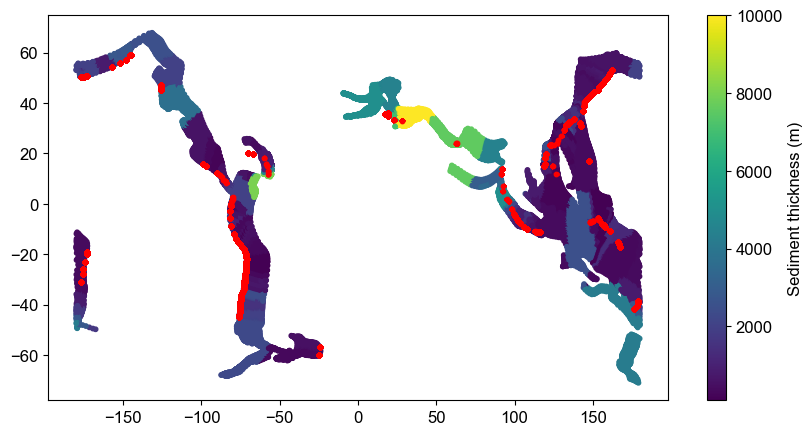

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
for age in np.arange(0, 56, 1):
    slab_data = M2016_slabs.data[age]["opt2"]
    p = ax.scatter(
        slab_data.lon, slab_data.lat,
        c = slab_data.sediment_thickness,
        cmap = "viridis",
        s = 10,
    )
    ax.scatter(
        lons, modern_slab_data.lat,
        c = "red", s = 10, label = "Modern slab data"
    )
fig.colorbar(p, label="Sediment thickness (m)")

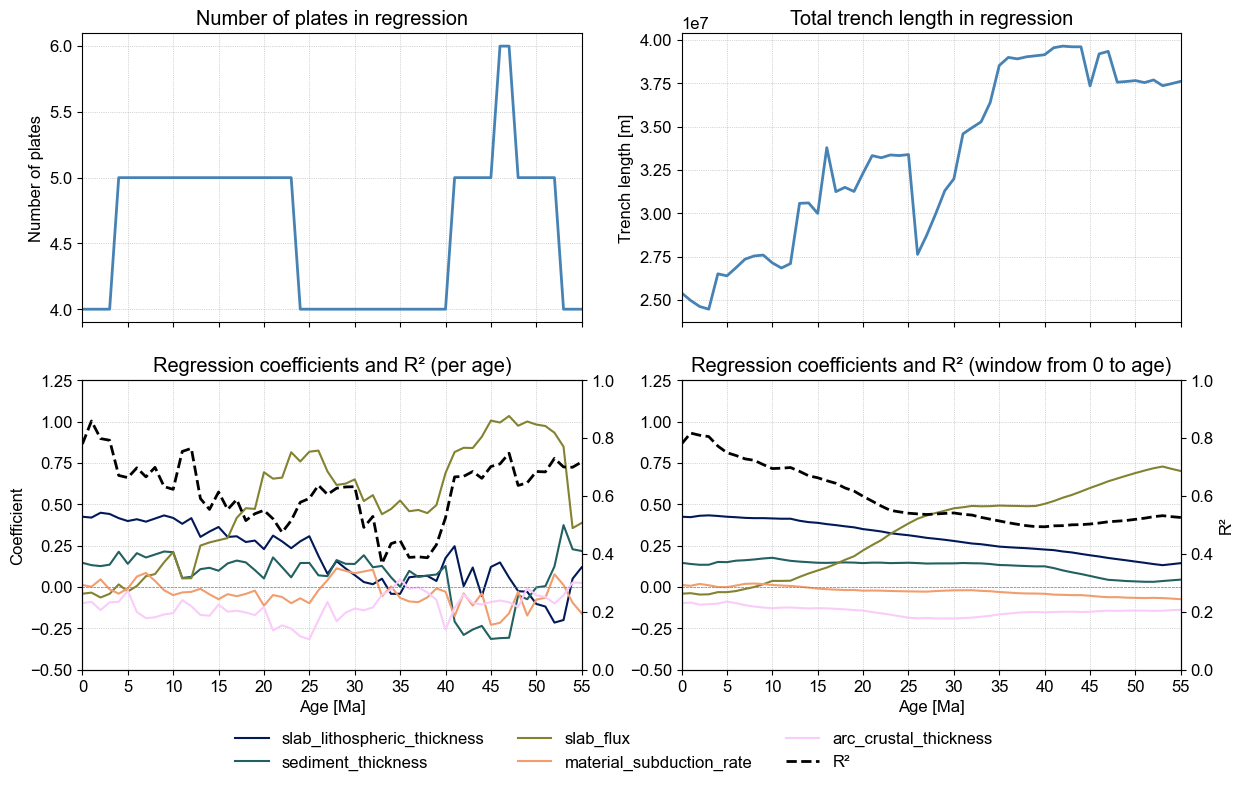

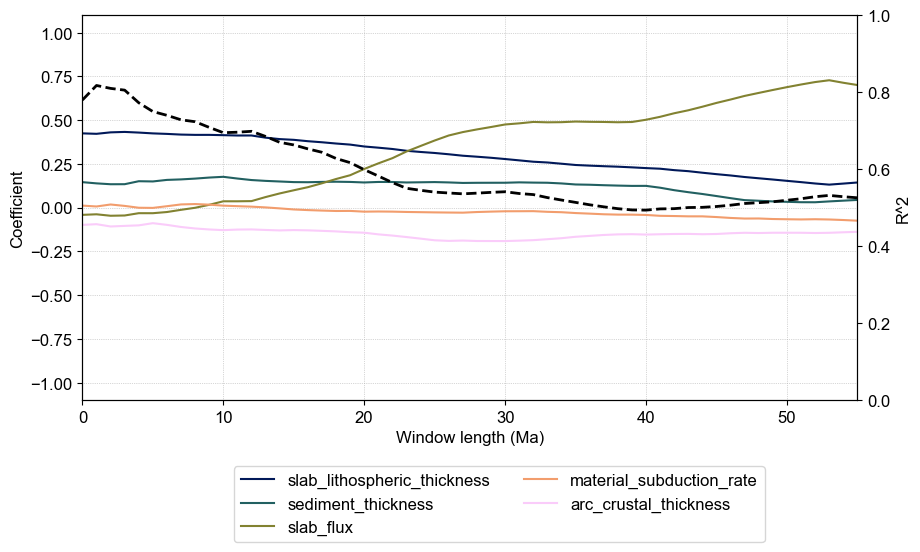

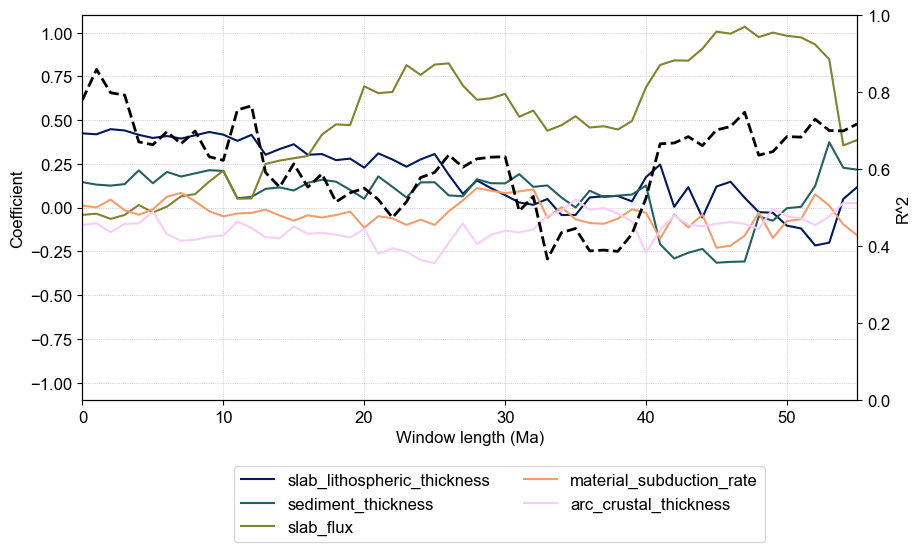

In [ ]:
colours = plt.get_cmap("cmc.batlow")(
    np.linspace(0, 1, len(columns_of_interest))
)

for use_window in [True, False]:
    fig, ax = plt.subplots(figsize=(10, 5))
    # ax.hlines(y=0, xmin=0, xmax=color="black", lw=0.5, linestyle="--")
    for col in columns_of_interest:
        ax.plot(max_ages, results[use_window]["coefficients"][col], label=col, color=colours[columns_of_interest.index(col)])

    twin_ax = ax.twinx()
    twin_ax.plot(max_ages, results[use_window]["r_squared"], label="R^2", linestyle="--", color="black", lw=2)

    handles, labels = ax.get_legend_handles_labels()
    handles += twin_ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.185, -0.15), ncol=2)
    ax.set_xlabel("Window length (Ma)")
    ax.set_ylabel("Coefficient")
    twin_ax.set_ylabel("R^2")
    ax.grid(linestyle=":", linewidth=0.5)
    ax.set_xlim(max_ages[0], max_ages[-1])
    ax.set_ylim(-1.1, 1.1)
    twin_ax.set_ylim(0, 1)

    plt.show()

In [ ]:
a

In [ ]:
# Columns of interest
columns_of_interest = [
    "slab_lithospheric_thickness",
    "sediment_thickness",
    "slab_flux",
    "material_subduction_rate",
    # "wedge_width",
    "arc_crustal_thickness"
]

# Initialise lists to store coefficients
coefficients = {col: [] for col in columns_of_interest}
r_squareds = []

# Define ages of interest
max_ages = np.arange(0,56,1)

# Select data
for max_age in max_ages+1:
    x_multi_list = []
    y_multi_list = []

    for age in np.arange(0, max_age, 1):
        # Initialise lists to store slab flux for the current age
        lats, lons, fluxes, coeffs = [], [], [], []

        # Calculate last 100 Ma of slab flux for the current age
        for _age in np.arange(age, age+101, 1):
            slab_data = M2016_slabs.data[_age]["opt2"].copy(deep=True)
            slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs)]

            # Calculate thicknesses
            slab_flux = (slab_data.slab_lithospheric_thickness + slab_data.slab_crustal_thickness) * slab_data.convergence_velocity_mag/1e2 * slab_data.trench_segment_length * 1e6

            # Append values
            lats.extend(slab_data.lat.values); lons.extend(slab_data.lon.values); fluxes.extend(slab_flux); coeffs.extend(slab_data.slab_pull_constant.values)

        # Convert to numpy arrays
        lats = np.array(lats); lons = np.array(lons); fluxes = np.array(fluxes)

        # Select data for the current age
        slab_data = M2016_slabs.data[age]["opt2"].copy(deep=True)
        slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs)]

        # Convert to Cartesian
        xyz_A = latlon_to_xyz(slab_data.lat, slab_data.lon)
        xyz_B = latlon_to_xyz(lats, lons)

        # Build tree
        tree_B = cKDTree(xyz_B)

        # Maximum spherical distance = 20 degrees converted to chord length on unit sphere
        max_angle_rad = np.radians(20)
        max_chord_dist = 2 * np.sin(max_angle_rad / 2)

        # Query neighbors indices for all points in A
        neighbors_idx = tree_B.query_ball_point(xyz_A, r=max_chord_dist)

        # Sum values of neighbors for each point in A
        slab_data["slab_flux"] = np.array([fluxes[idx].sum() if len(idx) > 0 else 0 for idx in neighbors_idx])

        M2016_slabs.data[age]["opt2"]["slab_flux"] = slab_data["slab_flux"]

        # Remove rows with all NaNs
        slab_data = slab_data.dropna(axis=0, how='all')

        # Drop rows with NaNs in predictors or target
        slab_data = slab_data.dropna(subset=columns_of_interest + ["slab_pull_constant", "trench_segment_length"])

        # Weighted feature matrix: multiply each row by trench_segment_length
        weights = slab_data.trench_segment_length.values[:, np.newaxis]
        features = slab_data[columns_of_interest].values * weights

        # Append to lists
        x_multi_list.append(features)
        y_multi_list.append(slab_data.slab_pull_constant.values * slab_data.trench_segment_length.values)

    # Convert lists to numpy arrays
    x_multi = np.vstack(x_multi_list)
    y_multi = np.concatenate(y_multi_list)

    # Normalise predictors
    x_multi = (x_multi - np.nanmean(x_multi, axis=0)) / np.nanstd(x_multi, axis=0)

    # Normalise target
    y_multi = (y_multi - np.nanmean(y_multi)) / np.nanstd(y_multi)

    model = LinearRegression()
    model.fit(x_multi, y_multi)
    print(f"Window length: {max_age} Ma, R^2:", model.score(x_multi, y_multi))

    # Append feature importances
    for col, coef in zip(columns_of_interest, model.coef_):
        coefficients[col].append(coef)
    
    # Append R^2
    r_squareds.append(model.score(x_multi, y_multi))

Window length: 1 Ma, R^2: 0.7909429852851684
Window length: 2 Ma, R^2: 0.8286913449267455
Window length: 3 Ma, R^2: 0.8177824048961977
Window length: 4 Ma, R^2: 0.8152299263923407
Window length: 5 Ma, R^2: 0.7842341630667197
Window length: 6 Ma, R^2: 0.7602528727419402
Window length: 7 Ma, R^2: 0.7496200634963157
Window length: 8 Ma, R^2: 0.7366060291495165
Window length: 9 Ma, R^2: 0.7316826486703114
Window length: 10 Ma, R^2: 0.7179986781253547
Window length: 11 Ma, R^2: 0.7052636833472262
Window length: 12 Ma, R^2: 0.7064105283671214
Window length: 13 Ma, R^2: 0.7088941118563692
Window length: 14 Ma, R^2: 0.696731698172009
Window length: 15 Ma, R^2: 0.6828044099036279
Window length: 16 Ma, R^2: 0.6778305518851689
Window length: 17 Ma, R^2: 0.6690971556993963
Window length: 18 Ma, R^2: 0.6615235489102318
Window length: 19 Ma, R^2: 0.6462693453701274
Window length: 20 Ma, R^2: 0.6359626359257541
Window length: 21 Ma, R^2: 0.6188423211411911
Window length: 22 Ma, R^2: 0.602416605395751

NameError: name 'coefficients' is not defined

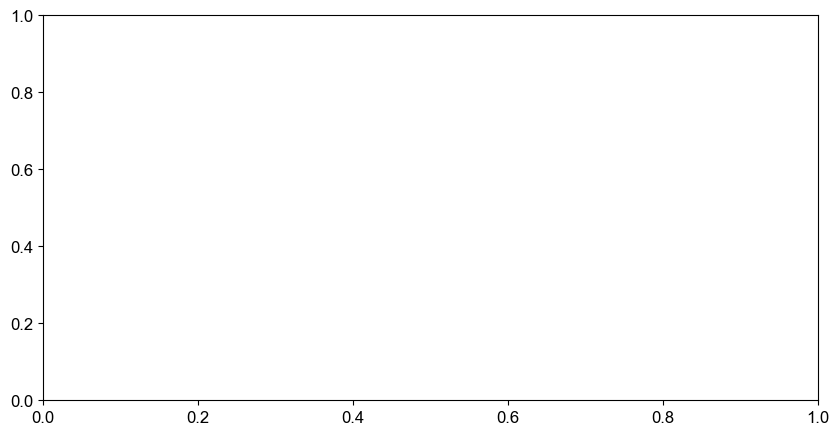

In [ ]:
# Columns of interest
columns_of_interest = [
    "slab_seafloor_age",
    "sediment_thickness",
    "slab_flux",
    "material_subduction_rate",
    # "wedge_width",
    "arc_crustal_thickness"
]

# Initialise lists to store coefficients
coefficients = {col: [] for col in columns_of_interest}
r_squareds = []

# Define ages of interest
max_ages = np.arange(0,56,1)

# Select data
for age in max_ages:
    x_multi_list = []
    y_multi_list = []

    # Initialise lists to store slab flux for the current age
    lats, lons, fluxes, coeffs = [], [], [], []

    # Calculate last 100 Ma of slab flux for the current age
    for _age in np.arange(age, age+101, 1):
        slab_data = M2016_slabs.data[_age]["opt2"].copy(deep=True)
        slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs)]

        # Calculate thicknesses
        slab_flux = (slab_data.slab_lithospheric_thickness + slab_data.slab_crustal_thickness) * slab_data.convergence_velocity_mag/1e2 * slab_data.trench_segment_length * 1e6

        # Append values
        lats.extend(slab_data.lat.values); lons.extend(slab_data.lon.values); fluxes.extend(slab_flux); coeffs.extend(slab_data.slab_pull_constant.values)

    # Convert to numpy arrays
    lats = np.array(lats); lons = np.array(lons); fluxes = np.array(fluxes)

    # Select data for the current age
    slab_data = M2016_slabs.data[age]["opt2"].copy(deep=True)
    slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs)]

    # Convert to Cartesian
    xyz_A = latlon_to_xyz(slab_data.lat, slab_data.lon)
    xyz_B = latlon_to_xyz(lats, lons)

    # Build tree
    tree_B = cKDTree(xyz_B)

    # Maximum spherical distance = 20 degrees converted to chord length on unit sphere
    max_angle_rad = np.radians(20)
    max_chord_dist = 2 * np.sin(max_angle_rad / 2)

    # Query neighbors indices for all points in A
    neighbors_idx = tree_B.query_ball_point(xyz_A, r=max_chord_dist)

    # Sum values of neighbors for each point in A
    slab_data["slab_flux"] = np.array([fluxes[idx].sum() if len(idx) > 0 else 0 for idx in neighbors_idx])

    M2016_slabs.data[age]["opt2"]["slab_flux"] = slab_data["slab_flux"]

    # Remove rows with all NaNs
    slab_data = slab_data.dropna(axis=0, how='all')

    # Drop rows with NaNs in predictors or target
    slab_data = slab_data.dropna(subset=columns_of_interest + ["slab_pull_constant", "trench_segment_length"])

    # Weighted feature matrix: multiply each row by trench_segment_length
    weights = slab_data.trench_segment_length.values[:, np.newaxis]
    features = slab_data[columns_of_interest].values * weights

    # Append to lists
    x_multi_list.append(features)
    y_multi_list.append(slab_data.slab_pull_constant.values * slab_data.trench_segment_length.values)

    # Convert lists to numpy arrays
    x_multi = np.vstack(x_multi_list)
    y_multi = np.concatenate(y_multi_list)

    # Normalise predictors
    x_multi = (x_multi - np.nanmean(x_multi, axis=0)) / np.nanstd(x_multi, axis=0)

    # Normalise target
    y_multi = (y_multi - np.nanmean(y_multi)) / np.nanstd(y_multi)

    model = LinearRegression()
    model.fit(x_multi, y_multi)
    print(f"Window length: {max_age} Ma, R^2:", model.score(x_multi, y_multi))

    # Append feature importances
    for col, coef in zip(columns_of_interest, model.coef_):
        coefficients[col].append(coef)
    
    # Append R^2
    r_squareds.append(model.score(x_multi, y_multi))

Window length: 56 Ma, R^2: 0.6666658643644601
Window length: 56 Ma, R^2: 0.7593420190490363
Window length: 56 Ma, R^2: 0.6904352638672533
Window length: 56 Ma, R^2: 0.7003508888590099
Window length: 56 Ma, R^2: 0.5938021377749378
Window length: 56 Ma, R^2: 0.5768897332743548
Window length: 56 Ma, R^2: 0.6248004461702255
Window length: 56 Ma, R^2: 0.5977346758572046
Window length: 56 Ma, R^2: 0.6289641043953743
Window length: 56 Ma, R^2: 0.5751459349692913
Window length: 56 Ma, R^2: 0.5554005658227699
Window length: 56 Ma, R^2: 0.6859574150785274
Window length: 56 Ma, R^2: 0.6791841751033675
Window length: 56 Ma, R^2: 0.5388551912278481
Window length: 56 Ma, R^2: 0.5170574290920498
Window length: 56 Ma, R^2: 0.5678963037632307
Window length: 56 Ma, R^2: 0.546524366226315
Window length: 56 Ma, R^2: 0.5649625578662192
Window length: 56 Ma, R^2: 0.49591084503772853
Window length: 56 Ma, R^2: 0.516806815575398
Window length: 56 Ma, R^2: 0.565740167604924
Window length: 56 Ma, R^2: 0.5376291

NameError: name 'coefficients' is not defined

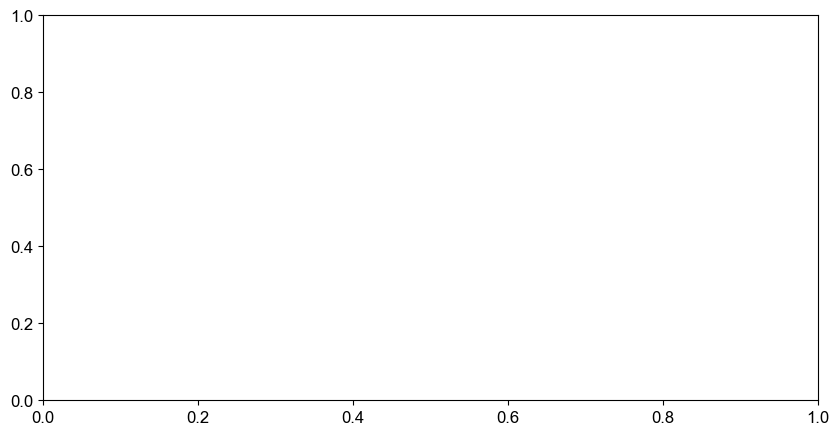

In [ ]:
colours = plt.get_cmap("cmc.batlow")(
    np.linspace(0, 1, len(columns_of_interest))
)

fig, ax = plt.subplots(figsize=(10, 5))
# ax.hlines(y=0, xmin=0, xmax=color="black", lw=0.5, linestyle="--")
for col in columns_of_interest:
    ax.plot(max_ages, coefficients[col], label=col, color=colours[columns_of_interest.index(col)])

twin_ax = ax.twinx()
twin_ax.plot(max_ages, r_squareds, label="R^2", linestyle="--", color="black", lw=2)

handles, labels = ax.get_legend_handles_labels()
handles += twin_ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.185, -0.15), ncol=2)
ax.set_xlabel("Window length (Ma)")
ax.set_ylabel("Coefficient")
twin_ax.set_ylabel("R^2")
ax.grid(linestyle=":", linewidth=0.5)
ax.set_xlim(max_ages[0], max_ages[-1])
ax.set_ylim(-.5, 1)
twin_ax.set_ylim(0, 1)

plt.show()

In [ ]:
# Columns of interest for regression
columns_of_interest = [
    "slab_lithospheric_thickness",
    "sediment_thickness",
    "slab_flux",
    "material_subduction_rate",
    "arc_crustal_thickness"
]

max_ages = np.arange(0, 56, 1)

# Dictionaries to store results
results = {
    True: {  # key True for use_window = True
        "coefficients": {col: [] for col in columns_of_interest},
        "r_squared": []
    },
    False: {  # key False for use_window = False
        "coefficients": {col: [] for col in columns_of_interest},
        "r_squared": []
    }
}

for use_window in [True, False]:
    for age in max_ages:
        x_multi_list = []
        y_multi_list = []

        if use_window:
            age_range = np.arange(age, age + 101, 1)
        else:
            age_range = [age]

        lats, lons, fluxes = [], [], []

        for _age in age_range:
            slab_data = M2016_slabs.data[_age]["opt2"].copy(deep=True)
            slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs)]

            slab_flux = (
                (slab_data.slab_lithospheric_thickness + slab_data.slab_crustal_thickness) *
                slab_data.convergence_velocity_mag / 1e2 *
                slab_data.trench_segment_length * 1e6
            )

            lats.extend(slab_data.lat.values)
            lons.extend(slab_data.lon.values)
            fluxes.extend(slab_flux)

        lats = np.array(lats)
        lons = np.array(lons)
        fluxes = np.array(fluxes)

        slab_data = M2016_slabs.data[age]["opt2"].copy(deep=True)
        slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs)]

        xyz_A = latlon_to_xyz(slab_data.lat, slab_data.lon)
        xyz_B = latlon_to_xyz(lats, lons)

        tree_B = cKDTree(xyz_B)

        max_angle_rad = np.radians(20)
        max_chord_dist = 2 * np.sin(max_angle_rad / 2)

        neighbors_idx = tree_B.query_ball_point(xyz_A, r=max_chord_dist)

        slab_data["slab_flux"] = np.array([
            fluxes[idx].sum() if len(idx) > 0 else 0
            for idx in neighbors_idx
        ])

        M2016_slabs.data[age]["opt2"]["slab_flux"] = slab_data["slab_flux"]

        slab_data = slab_data.dropna(axis=0, how='all')
        slab_data = slab_data.dropna(subset=columns_of_interest + ["slab_pull_constant", "trench_segment_length"])

        # Normalise predictors
        slab_data[columns_of_interest] = (slab_data[columns_of_interest] - slab_data[columns_of_interest].mean()) / slab_data[columns_of_interest].std()

        weights = slab_data.trench_segment_length.values[:, np.newaxis]
        features = slab_data[columns_of_interest].values * weights
        targets = slab_data.slab_pull_constant.values * slab_data.trench_segment_length.values

        x_multi_list.append(features)
        y_multi_list.append(targets)

        x_multi = np.vstack(x_multi_list)
        y_multi = np.concatenate(y_multi_list)

        model = LinearRegression()
        model.fit(x_multi, y_multi)

        r2 = model.score(x_multi, y_multi)
        # print(f"Age: {age}, Use window: {use_window}, R^2: {r2:.4f}")

        for col, coef in zip(columns_of_interest, model.coef_):
            results[use_window]["coefficients"][col].append(coef)

        results[use_window]["r_squared"].append(r2)

NameError: name 'max_ages' is not defined

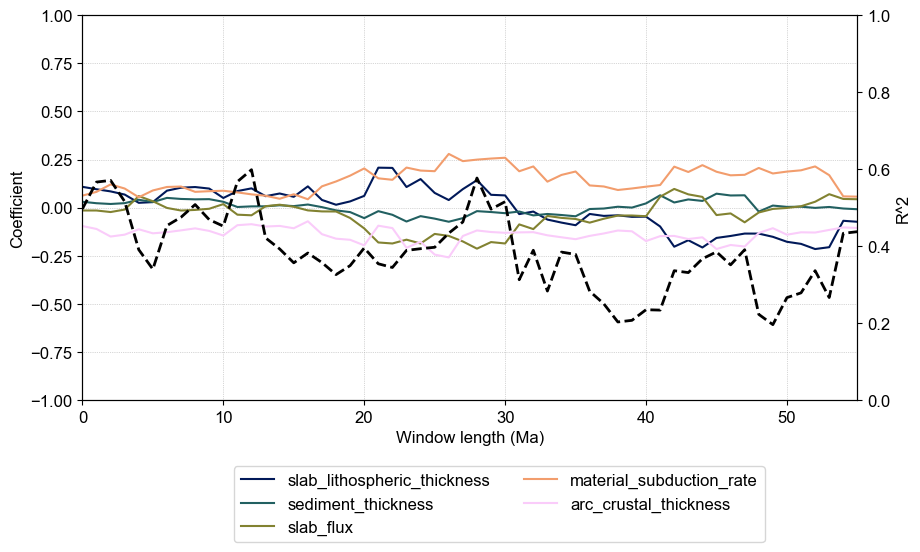

In [ ]:
colours = plt.get_cmap("cmc.batlow")(
    np.linspace(0, 1, len(columns_of_interest))
)

fig, ax = plt.subplots(figsize=(10, 5))
# ax.hlines(y=0, xmin=0, xmax=color="black", lw=0.5, linestyle="--")
for col in columns_of_interest:
    ax.plot(max_ages, results[False]["coefficients"][col], label=col, color=colours[columns_of_interest.index(col)])

twin_ax = ax.twinx()
twin_ax.plot(max_ages, results[False]["r_squared"], label="R^2", linestyle="--", color="black", lw=2)

handles, labels = ax.get_legend_handles_labels()
handles += twin_ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.185, -0.15), ncol=2)
ax.set_xlabel("Window length (Ma)")
ax.set_ylabel("Coefficient")
twin_ax.set_ylabel("R^2")
ax.grid(linestyle=":", linewidth=0.5)
ax.set_xlim(max_ages[0], max_ages[-1])
ax.set_ylim(-1, 1)
twin_ax.set_ylim(0, 1)

plt.show()

In [ ]:
a

NameError: name 'a' is not defined

In [ ]:
# Calculate slab flux for the last 200 Ma
lats = []; lons = []; fluxes = []; coeffs = []
for age in np.arange(0, 201, 1):
    # Select data
    slab_data = M2016_slabs.data[age]["opt2"]
    slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs)]

    # Calculate thicknesses
    slab_flux = (slab_data.slab_lithospheric_thickness + slab_data.slab_crustal_thickness) * slab_data.convergence_velocity_mag/1e2# * slab_data.trench_segment_length * 1e6

    # Append values
    lats.extend(slab_data.lat.values); lons.extend(slab_data.lon.values); fluxes.extend(slab_flux); coeffs.extend(slab_data.slab_pull_constant.values)

# Convert to numpy arrays
lats = np.array(lats); lons = np.array(lons); fluxes = np.array(fluxes); coeffs = np.array(coeffs)

In [ ]:
for age in M2016.ages:
    M2016.grids.sediment[age] = globsed

M2016.options["ref"]["Sample sediment grid"] = "z"

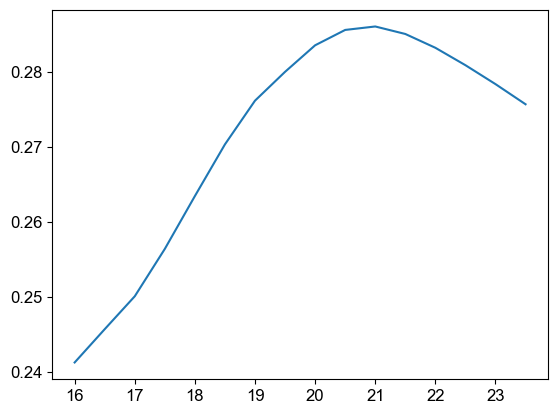

In [ ]:
fig, ax = plt.subplots()
ax.plot(r_squareds)
ax.set_xticklabels(np.arange(15, 31, 1))
plt.show()

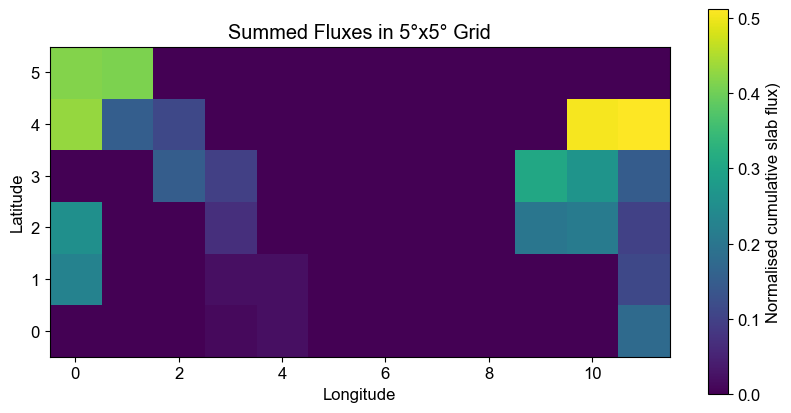

In [ ]:
# Define grid resolution
lat_res = 30
lon_res = 30

# Define grid origin (minimum corner)
lat_min, lat_max = -90, 90
lon_min, lon_max = -180, 180

# Compute number of grid cells
n_lat = int((lat_max - lat_min) / lat_res)
n_lon = int((lon_max - lon_min) / lon_res)

# Compute grid cell indices for each point
lat_idx = ((lats - lat_min) // lat_res).astype(int)
lon_idx = ((lons - lon_min) // lon_res).astype(int)

# Clamp indices within bounds (in case of rounding)
lat_idx = np.clip(lat_idx, 0, n_lat - 1)
lon_idx = np.clip(lon_idx, 0, n_lon - 1)

# Create DataFrame for grouping
df = pd.DataFrame({
    "lat_idx": lat_idx,
    "lon_idx": lon_idx,
    "flux": fluxes,
    "coeff": coeffs
})

# Group and aggregate: sum flux, average coeff
grid_agg = df.groupby(["lat_idx", "lon_idx"]).agg({
    "flux": "sum",
    "coeff": lambda x: np.nanmean(x)
}).reset_index()

# Initialize empty grid
flux_grid = np.zeros((n_lat, n_lon))
coeff_grid = np.zeros((n_lat, n_lon))

# Fill grid with summed fluxes
for _, row in grid_agg.iterrows():
    flux_grid[int(row["lat_idx"]), int(row["lon_idx"])] = row["flux"]
    coeff_grid[int(row["lat_idx"]), int(row["lon_idx"])] = row["coeff"]

# Earth's radius in km
R = 6371.0
deg2rad = np.pi / 180
delta_lambda = lon_res * deg2rad

# Latitude bin centers and bounds
latitudes = np.arange(lat_min, lat_max, lat_res)
lat_bounds = [(lat, lat + lat_res) for lat in latitudes]

# Compute area of each latitude band (same across all longitudes)
cell_areas = np.zeros(n_lat)
for i, (lat1, lat2) in enumerate(lat_bounds):
    phi1 = lat1 * deg2rad
    phi2 = lat2 * deg2rad
    area = R**2 * delta_lambda * (np.sin(phi2) - np.sin(phi1))  # in km²
    cell_areas[i] = abs(area)

# Normalize flux grid by area
for i in range(n_lat):
    flux_grid[i, :] /= cell_areas[i]

# Store grid in an xarray Dataset
flux_grid_ds = xr.Dataset(
    {
        "slab_flux": (["latitude", "longitude"], flux_grid),
        "coefficient": (["latitude", "longitude"], coeff_grid)
    },
    coords={
        "latitude": np.arange(lat_min, lat_max, lat_res),
        "longitude": np.arange(lon_min, lon_max, lon_res)
    }
)

In [ ]:
M2016_slabs.sample_grid(
    grids = {age: flux_grid_ds for age in M2016_slabs.ages},
    plate = "lower",
    vars = ["slab_flux"],
    cols = ["cumulative_slab_flux"],
)

Sampling slabs: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


In [ ]:
M2016.slabs.sample_grid(
    grids = flux_grids,
    plate = "lower",
    vars = ["slab_flux"],
    cols = ["cumulative_slab_flux"],
)

Sampling slabs: 100%|██████████| 1/1 [00:00<00:00, 82.79it/s]


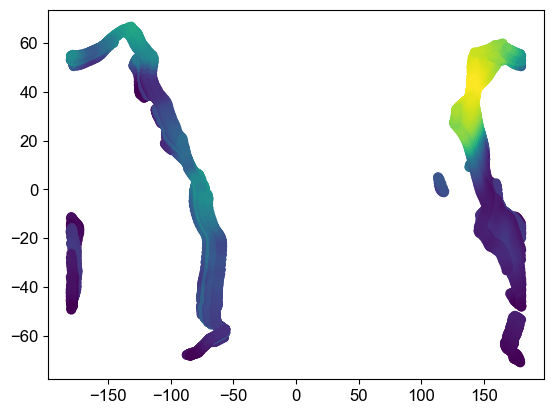

In [ ]:
for age in np.arange(0,51,1):
    data = M2016_slabs.data[age]["opt2"]
    data = data[data.lower_plateID.isin(plateIDs)]
    plt.scatter(
        data.lon,
        data.lat,
        c=data.slab_flux,
    )

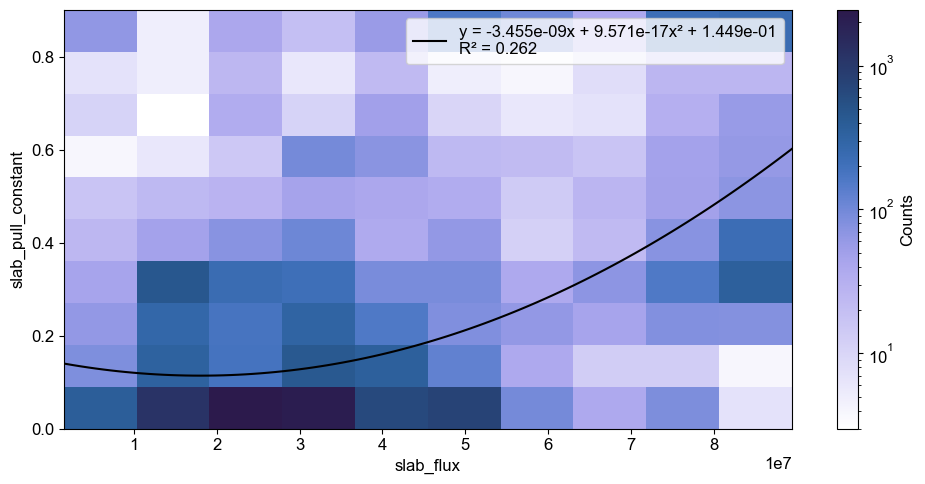

Linear regression coefficients: [[ 0.00000000e+00 -3.45453810e-09  9.57123168e-17]]
Intercept: [0.14488958]
R²: 0.262


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

x = []; y = []

for age in np.arange(0,51,1):
    data = M2016_slabs.data[age]["opt2"].copy()
    data = data[data.lower_plateID.isin(plateIDs)]
    data = data[~np.isnan(data.slab_pull_constant)]
    data = data[~np.isnan(data.slab_flux)]
    x.extend(data.slab_flux.values)
    y.extend(data.slab_pull_constant.values)

# Assuming x and y are prepared as in your code
x = np.array(x).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)

# Polynomial feature transform (degree=2)
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x)

# Fit linear regression on polynomial-transformed features
model = LinearRegression().fit(x_poly, y)

# Predict and compute R²
y_pred = model.predict(x_poly)
r_squared = r2_score(y, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# 2D histogram on original x vs y
p = ax.hist2d(
    x.flatten(), y.flatten(),
    bins=10,
    cmap="cmc.devon_r",
    norm=mcolors.LogNorm(),
)

# Polynomial regression curve (fitted)
x_fit = np.linspace(0, np.nanmax(x), 100).reshape(-1, 1)
x_fit_poly = poly.transform(x_fit)
y_fit = model.predict(x_fit_poly)

ax.plot(
    x_fit,
    y_fit,
    color="black",
    label=f"y = {model.coef_[0][1]:.3e}x + {model.coef_[0][2]:.3e}x² + {model.intercept_[0]:.3e}\nR² = {r_squared:.3f}"
)
ax.legend()

plt.colorbar(p[3], ax=ax, label="Counts")
ax.set_xlabel("slab_flux")
ax.set_ylabel("slab_pull_constant")
plt.tight_layout()
plt.show()

# Print the coefficients
print(f"Linear regression coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
# Print the R² value
print(f"R²: {r_squared:.3f}")

In [ ]:
M2016_slabs.data[0]["ref"].columns

Index(['index', 'lon', 'lat', 'trench_segment_length', 'trench_normal_azimuth',
       'lower_plateID', 'trench_plateID', 'slab_sampling_lat',
       'slab_sampling_lon', 'arc_sampling_lat', 'arc_sampling_lon',
       'upper_plateID', 'upper_plate_velocity_lat', 'upper_plate_velocity_lon',
       'upper_plate_velocity_mag', 'lower_plate_velocity_lat',
       'lower_plate_velocity_lon', 'lower_plate_velocity_mag',
       'trench_velocity_lat', 'trench_velocity_lon', 'trench_velocity_mag',
       'convergence_velocity_lat', 'convergence_velocity_lon',
       'convergence_velocity_mag', 'arc_thickness', 'arc_seafloor_age',
       'continental_arc', 'erosion_rate', 'slab_seafloor_age',
       'slab_lithospheric_thickness', 'slab_crustal_thickness',
       'slab_water_depth', 'shear_zone_width', 'sediment_thickness',
       'sediment_fraction', 'slab_length', 'slab_pull_force_mag',
       'slab_pull_force_lat', 'slab_pull_force_lon', 'slab_bend_force_mag',
       'slab_bend_force_lat', 'sla

In [ ]:
# Columns of interest
columns_of_interest = [
    "slab_seafloor_age",
    "sediment_thickness",
    "slab_flux",
    "material_subduction_rate",
    "wedge_width",
    "arc_crustal_thickness"
]

x_multi_list = []
y_multi_list = []

# Select data
for age in np.arange(0, 15, 1):
    slab_data = M2016_slabs.data[age]["opt2"].copy(deep=True)
    slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs)]

    # Remove rows with all NaNs
    slab_data = slab_data.dropna(axis=0, how='all')

    # Drop rows with NaNs in predictors or target
    slab_data = slab_data.dropna(subset=columns_of_interest + ["slab_pull_constant", "trench_segment_length"])

    # Weighted feature matrix: multiply each row by trench_segment_length
    weights = slab_data.trench_segment_length.values[:, np.newaxis]
    features = slab_data[columns_of_interest].values * weights

    if slab_data.margin_age < age:
        slab_data[""]

    x_multi_list.append(features)
    y_multi_list.append(slab_data["slab_pull_constant"].values)

# Combine all data
x_multi = np.vstack(x_multi_list)
y_multi = np.concatenate(y_multi_list)

# Normalise predictors
x_multi = (x_multi - np.nanmean(x_multi, axis=0)) / np.nanstd(x_multi, axis=0)

r_squareds = []
for degree in np.arange(1, 4):
    # Polynomial feature transform
    multi_poly = PolynomialFeatures(degree=degree, interaction_only=True)
    x_multi_poly = multi_poly.fit_transform(x_multi)

    # Fit linear regression on polynomial-transformed features
    model = LinearRegression().fit(x_multi_poly, y_multi)

    # Predict and compute R²
    y_multi_pred = model.predict(x_multi_poly)
    r_squared_multi = r2_score(y_multi, y_multi_pred)

    feature_names = multi_poly.get_feature_names_out(input_features=columns_of_interest)

    # Print the coefficients for the multivariate regression
    # for name, coef in zip(feature_names, model.coef_):
    #     print(f"{name}: {coef:.3e}")
    # print(f"Intercept: {model.intercept_}")
    print(f"Polynomial of degree: {degree}, R²: {r_squared_multi:.3f}")
    r_squareds.append(r_squared_multi)

    # # Plot coefficients as bar chart
    # plt.figure(figsize=(10, 10))
    # plt.barh(feature_names, model.coef_)
    # plt.xlabel("Coefficient Value")
    # plt.title("Multivariate Linear Regression Coefficients")
    # plt.axvline(0, color='black', linestyle='--')
    # plt.grid(axis='x')
    # plt.tight_layout()

# plt.plot(r_squareds)

Polynomial of degree: 1, R²: 0.281
Polynomial of degree: 2, R²: 0.384
Polynomial of degree: 3, R²: 0.457


PCA with 3 components, R²: 0.266
slab_seafloor_age: 0.023
lat: 0.082
convergence_velocity_mag: -0.013
sediment_thickness: -0.018
slab_flux: 0.061
material_subduction_rate: -0.004
wedge_width: -0.005
arc_crustal_thickness: -0.017
----------------------------------------


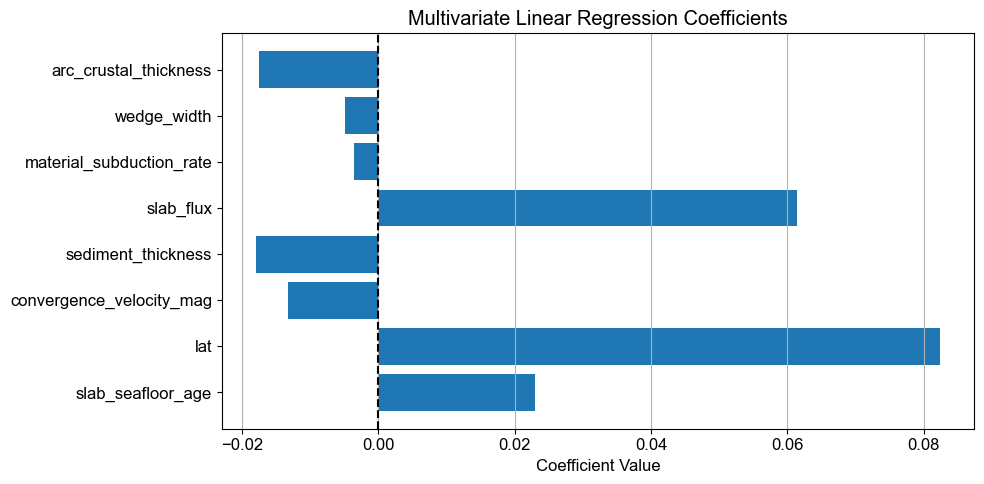

In [ ]:
from sklearn.decomposition import PCA

r_squareds = []
n_components_range = range(1, len(columns_of_interest) + 1)

for n_components in [3]:
    # Apply PCA to reduce features
    pca = PCA(n_components=n_components)
    x_multi_pca = pca.fit_transform(x_multi)

    # Fit linear regression on principal components
    model = LinearRegression().fit(x_multi_pca, y_multi)

    # Predict and compute R²
    y_multi_pred = model.predict(x_multi_pca)
    r_squared = r2_score(y_multi, y_multi_pred)

    print(f"PCA with {n_components} components, R²: {r_squared:.3f}")
    r_squareds.append(r_squared)

    # Print which components are used
    # Show component loadings (coefficients of each original feature in each component)
    # for i, comp in enumerate(pca.components_):
    #     print(f"Component {i+1} loadings:")
    #     for feature_name, loading in zip(columns_of_interest, comp):
    #         print(f"  {feature_name}: {loading:.3f}")

    # # Show regression coefficients on PCA components
    # print("Regression coefficients for each PCA component:")
    # for i, coef in enumerate(model.coef_):
    #     print(f"  PC{i+1}: {coef:.3f}")

    gamma = np.dot(model.coef_, pca.components_)
    for name, coef in zip(columns_of_interest, gamma):
        print(f"{name}: {coef:.3f}")

    print("-" * 40)

    # Plot coefficients as bar chart
    plt.figure(figsize=(10, 5))
    plt.barh(columns_of_interest, gamma)
    plt.xlabel("Coefficient Value")
    plt.title("Multivariate Linear Regression Coefficients")
    plt.axvline(0, color='black', linestyle='--')
    plt.grid(axis='x')
    plt.tight_layout()

# # (Optional) Plot R² vs number of PCA components
# plt.figure(figsize=(6,4))
# plt.plot(list(n_components_range), r_squareds, marker='o')
# plt.xlabel("Number of PCA Components")
# plt.ylabel("R² Score")
# plt.title("Linear Regression Performance on PCA Components")
# plt.grid(True)
# plt.tight_layout()
# plt.show()



R^2: 0.82075915362997
slab_seafloor_age: 0.527
sediment_thickness: 0.073
slab_flux: 0.129
material_subduction_rate: 0.101
wedge_width: 0.051
arc_crustal_thickness: 0.119


Selected features after RFE:
Selected features and coefficients:
arc_crustal_thickness: -1.21e-01
slab_seafloor_age wedge_width: -7.09e-02
slab_seafloor_age lat wedge_width: 9.41e-02
material_subduction_rate: 1.11e-01
lat: 1.47e-01
Intercept: 0.18675176917203445
R-squared: 0.3481826381695592
Adjusted R-squared: 0.34780555997805707


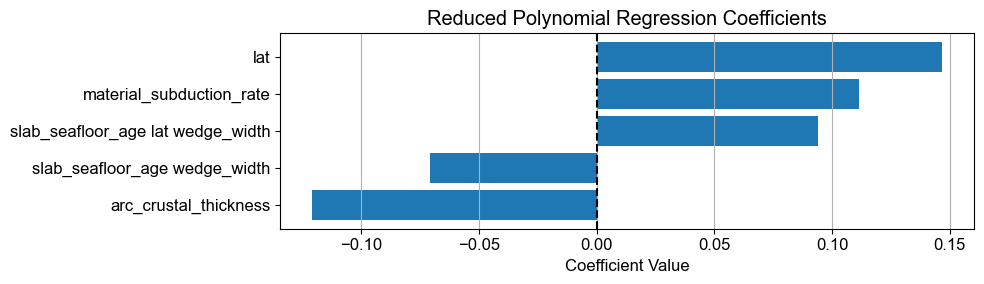

In [ ]:
# Reduce the number of features using RFE
from sklearn.feature_selection import RFE

# Step 2: Use RFE to reduce features
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(x_multi_poly, y_multi)

# Step 3: Transform the data to reduced feature set
x_multi_poly_reduced = selector.transform(x_multi_poly)
selected_features = [name for name, keep in zip(feature_names, selector.support_) if keep]

# Step 4: Fit a linear model on the reduced features
model_multi = LinearRegression().fit(x_multi_poly_reduced, y_multi)
y_pred = model_multi.predict(x_multi_poly_reduced)
r_squared = model_multi.score(x_multi_poly_reduced, y_multi)
adj_r_squared = 1 - (1 - r_squared) * (len(y_multi) - 1) / (len(y_multi) - len(selected_features) - 1)

# Sort the coefficients for better visualization
sorted_indices = np.argsort(model_multi.coef_)
model_multi.coef_ = model_multi.coef_[sorted_indices]
selected_features = [selected_features[i] for i in sorted_indices]

# Print the selected features and their coefficients
print("Selected features after RFE:")

# Step 5: Output results
print("Selected features and coefficients:")
for name, coef in zip(selected_features, model_multi.coef_):
    print(f"{name}: {coef:.2e}")

print("Intercept:", model_multi.intercept_)
print("R-squared:", r_squared)
print("Adjusted R-squared:", adj_r_squared)

# Step 6: Plot reduced coefficients
plt.figure(figsize=(10, 3))
plt.barh(selected_features, model_multi.coef_)
plt.xlabel("Coefficient Value")
plt.title("Reduced Polynomial Regression Coefficients")
plt.axvline(0, color='black', linestyle='--')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [ ]:
x = slab_data.material_subduction_rate.values.reshape(-1, 1)  # Convert to 2D (n_samples, 1)
y = slab_data.slab_pull_constant.values

model = LinearRegression().fit(x, y)

params = (model.coef_[0], model.intercept_)
r_squared = model.score(x, y)

# Output
print("Linear Regression (material subduction rate vs. slab pull coefficient):")
print("Slope:", params[0])
print("Intercept:", params[1])
print("R-squared:", r_squared)
print("Adjusted R-squared:", 1 - (1 - r_squared) * (len(y) - 1) / (len(y) - x.shape[1] - 1))

Linear Regression (material subduction rate vs. slab pull coefficient):
Slope: -0.0001500963938436694
Intercept: 0.21877375585593736
R-squared: 0.00234265808315548
Adjusted R-squared: -0.0005491023281976037


In [ ]:
# Calculate slab flux on a 5x5 grid
lats = []; lons = []; fluxes = []
for age in M2016_slabs.ages:
    # Select data
    slab_data = M2016_slabs.data[age]["ref"]

    # Calculate thicknesses
    

    slab_flux = (slab_data.slab_lithospheric_thickness + slab_data.slab_crustal_thickness) * slab_data.convergence_velocity_mag/1e2 * slab_data.trench_segment_length * 1e6

    # Append values
    lats.extend(slab_data.lat.values); lons.extend(slab_data.lon.values); fluxes.extend(slab_flux)

In [ ]:
M2016.save_all()

Saving Globe: 100%|██████████| 1/1 [00:00<00:00, 217.57it/s]


In [ ]:
# Create array with all values of latitude, seafloor age
lats = np.array([])
seafloor_ages = np.array([])
sp_coeffs = np.array([])

# Concentrate all values
for age in np.flip(np.arange(0, 91, 1)):
    # Select data
    slab_data = M2016_slabs.data[age]["opt2"]
    if age < 36:
        slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs + [608, 901])]
    elif age < 46:
        slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs + [901])]
    elif age < 56:
        slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs + [501, 901])]
    else:
        slab_data = slab_data[slab_data.lower_plateID.isin(plateIDs + [501])]

    # Clean data
    slab_data = slab_data[slab_data.slab_seafloor_age.notna()]

    # Append values
    lats = np.append(lats, slab_data.lat.values)
    seafloor_ages = np.append(seafloor_ages, slab_data.slab_seafloor_age.values)
    sp_coeffs = np.append(sp_coeffs, slab_data.slab_pull_constant.values)

    if age == 0:
        slab_data2 = M2016.slabs.data[age]["ref"]
        slab_data2 = slab_data2[slab_data2.lower_plateID.isin(plateIDs + [608, 901])]
        slab_data2 = slab_data2[slab_data2.slab_seafloor_age.notna()]
        sed_data = slab_data2.sediment_thickness.values
        lat_data = slab_data2.lat.values
        age_data = slab_data.slab_seafloor_age.values
        coeff_data = slab_data.slab_pull_constant.values

In [ ]:
print(sed_data.shape, slab_data.slab_pull_constant.values.shape)

(243,) (243,)


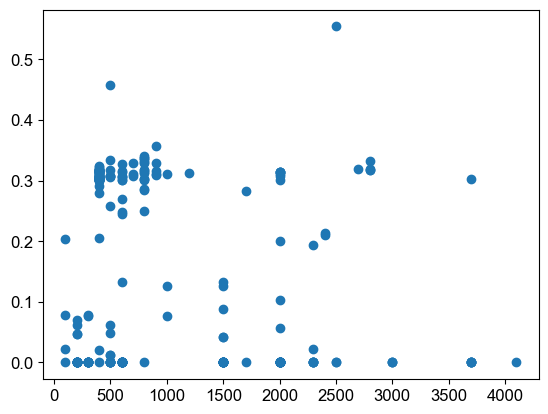

In [ ]:
plt.scatter(sed_data, slab_data.slab_pull_constant.values)

In [ ]:
# Reshape inputs for sklearn (expects 2D input)
seafloor_ages_reshaped = np.array(seafloor_ages).reshape(-1, 1)
lats_reshaped = np.array(lats).reshape(-1, 1)
sed_data_reshaped = np.array(sed_data).reshape(-1, 1)
sp_coeffs_array = np.array(sp_coeffs)
slab_pull_array = np.array(slab_data.slab_pull_constant.values)

# Age regression
model_age = LinearRegression().fit(seafloor_ages_reshaped, sp_coeffs_array)
age_params = (model_age.coef_[0], model_age.intercept_)
r_squared_age = model_age.score(seafloor_ages_reshaped, sp_coeffs_array)

# Latitude regression
model_lat = LinearRegression().fit(lats_reshaped, sp_coeffs_array)
lat_params = (model_lat.coef_[0], model_lat.intercept_)
r_squared_lat = model_lat.score(lats_reshaped, sp_coeffs_array)

# Sediment thickness regression
model_sed = LinearRegression().fit(sed_data_reshaped, slab_pull_array)
sed_params = (model_sed.coef_[0], model_sed.intercept_)
r_squared_sed = model_sed.score(sed_data_reshaped, slab_pull_array)

# Output
print("Seafloor Age Fit:       y = {:.3f}x + {:.3f}, R² = {:.3f}".format(*age_params, r_squared_age))
print("Latitude Fit:           y = {:.3f}x + {:.3f}, R² = {:.3f}".format(*lat_params, r_squared_lat))
print("Sediment Thickness Fit: y = {:.3f}x + {:.3f}, R² = {:.3f}".format(*sed_params, r_squared_sed))


Seafloor Age Fit:       y = 0.000x + 0.188, R² = 0.000
Latitude Fit:           y = 0.003x + 0.178, R² = 0.178
Sediment Thickness Fit: y = -0.000x + 0.198, R² = 0.051


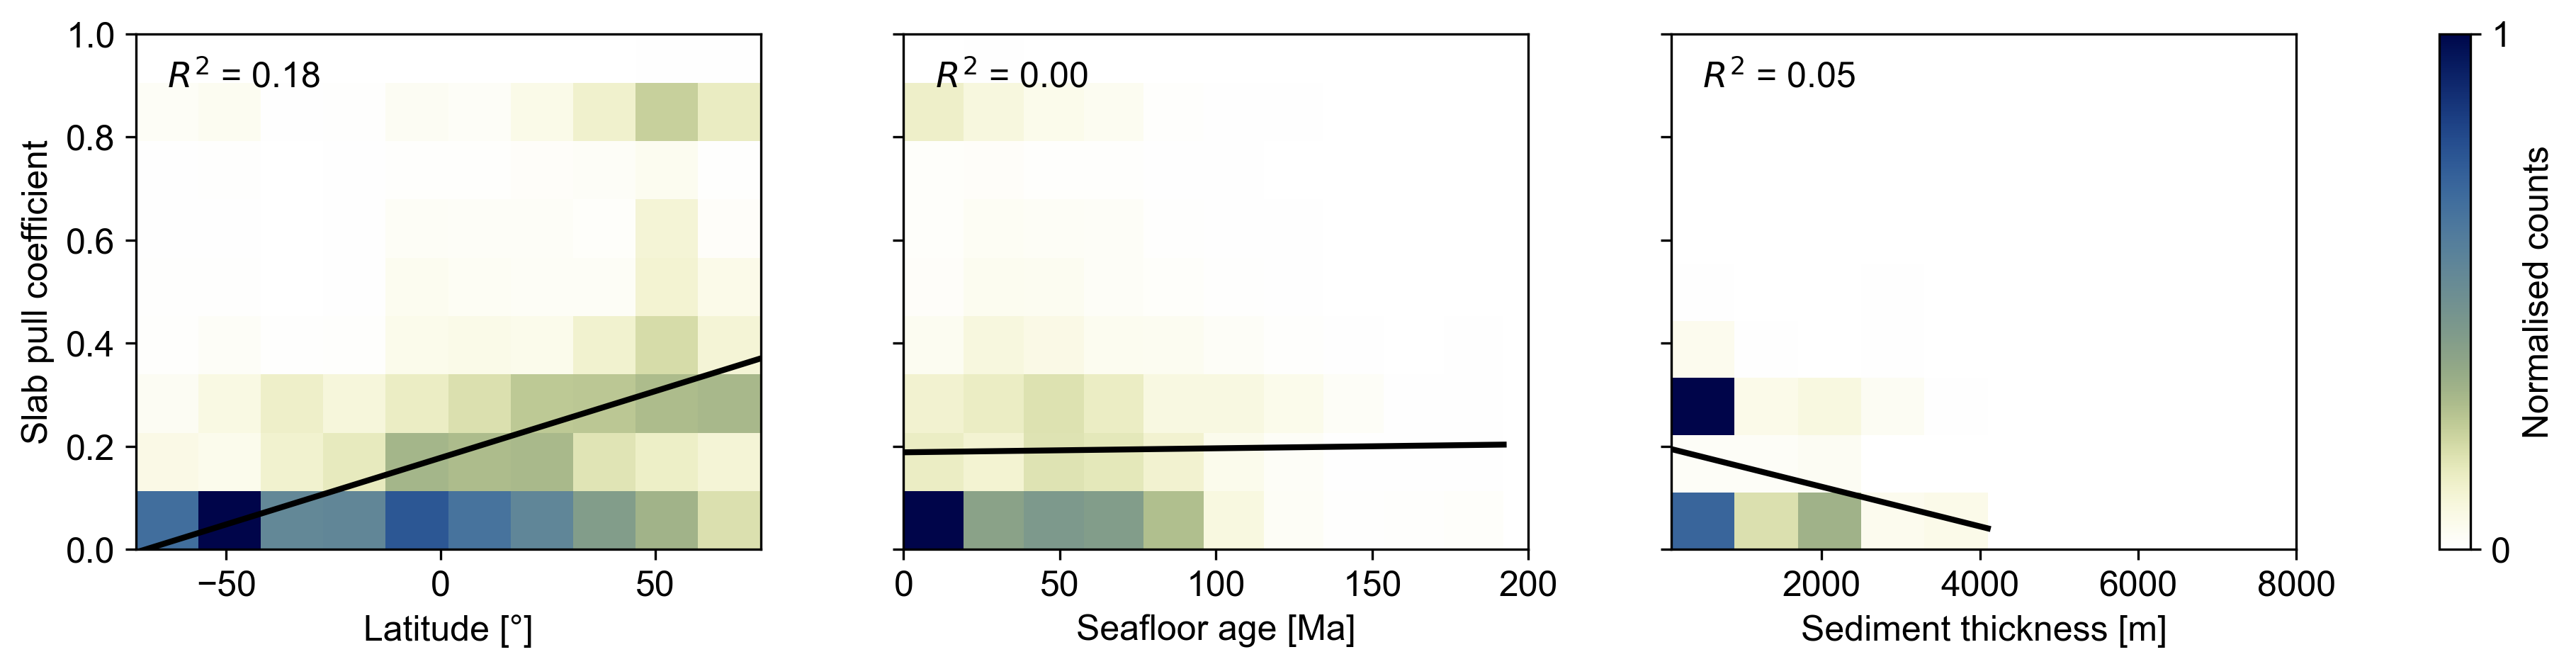

In [ ]:
# Set up the figure and gridspec
fig = plt.figure(figsize=(fig_width, fig_height_graphs / 2), dpi=300)
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.3)

# Create subplots
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
cax = fig.add_subplot(gs[3])  # Colorbar axis

# Create sorted x ranges for smooth lines
lat_sort = np.sort(lats)
age_sort = np.sort(seafloor_ages)
sed_sort = np.sort(sed_data)

# Predict values using sklearn models
lat_line = model_lat.predict(lat_sort.reshape(-1, 1))
age_line = model_age.predict(age_sort.reshape(-1, 1))
sed_line = model_sed.predict(sed_sort.reshape(-1, 1))

# Plot 1: Latitude vs. Slab pull coefficient
h0 = ax0.hist2d(lats, sp_coeffs, bins=10, cmap="cmc.davos_r", cmin=1)
ax0.plot(lat_sort, lat_line, color="black", lw=2)
ax0.set_xlabel("Latitude [°]")
ax0.set_ylabel("Slab pull coefficient")
ax0.set_ylim(0, 1)
ax0.text(0.05, 0.95, f"$R^2$ = {r_squared_lat:.2f}", transform=ax0.transAxes, fontsize=12, va='top')

# Plot 2: Seafloor age vs. Slab pull coefficient
h1 = ax1.hist2d(seafloor_ages, sp_coeffs, bins=10, cmap="cmc.davos_r", cmin=1)
ax1.plot(age_sort, age_line, color="black", lw=2)
ax1.set_xlabel("Seafloor age [Ma]")
ax1.set_ylim(0, 1)
ax1.set_xlim(0, 200)

ax1.set_yticklabels([])
ax1.text(0.05, 0.95, f"$R^2$ = {r_squared_age:.2f}", transform=ax1.transAxes, fontsize=12, va='top')

# Plot 3: Sediment thickness vs. Slab pull coefficient
h2 = ax2.hist2d(sed_data, slab_data.slab_pull_constant.values, bins=5, cmap="cmc.davos_r", cmin=1)
ax2.plot(sed_sort, sed_line, color="black", lw=2)
ax2.set_xlabel("Sediment thickness [m]")
ax2.set_ylim(0, 1)
ax2.set_xlim(1e2, 8e3)
ax2.set_yticklabels([])
ax2.text(0.05, 0.95, f"$R^2$ = {r_squared_sed:.2f}", transform=ax2.transAxes, fontsize=12, va='top')

# Add a colorbar using the last hist2d
cb = plt.colorbar(h2[3], cax=cax)
cb.set_label("Normalised counts")
cax.set_yticks([h2[3].get_array().min(), h2[3].get_array().max()])
cax.set_yticklabels([0,1])

plt.tight_layout()
plt.show()


In [ ]:
# Reshape and stack predictors into one feature matrix
X_multi = np.column_stack((lat_data, age_data, sed_data))
y_multi = np.array(coeff_data)

# Fit multivariate linear regression model
model_multi = LinearRegression().fit(X_multi, y_multi)

# Get coefficients and intercept
coefficients = model_multi.coef_
intercept = model_multi.intercept_
r_squared_multi = model_multi.score(X_multi, y_multi)

# Output
print("Multivariate Linear Regression:")
print("Model: y = {:.3f}*lat + {:.3f}*age + {:.3f}*sed + {:.3f}".format(
    coefficients[0], coefficients[1], coefficients[2], intercept))
print("R² = {:.3f}".format(r_squared_multi))


Multivariate Linear Regression:
Model: y = 0.001*lat + 0.002*age + 0.000*sed + -0.003
R² = 0.527


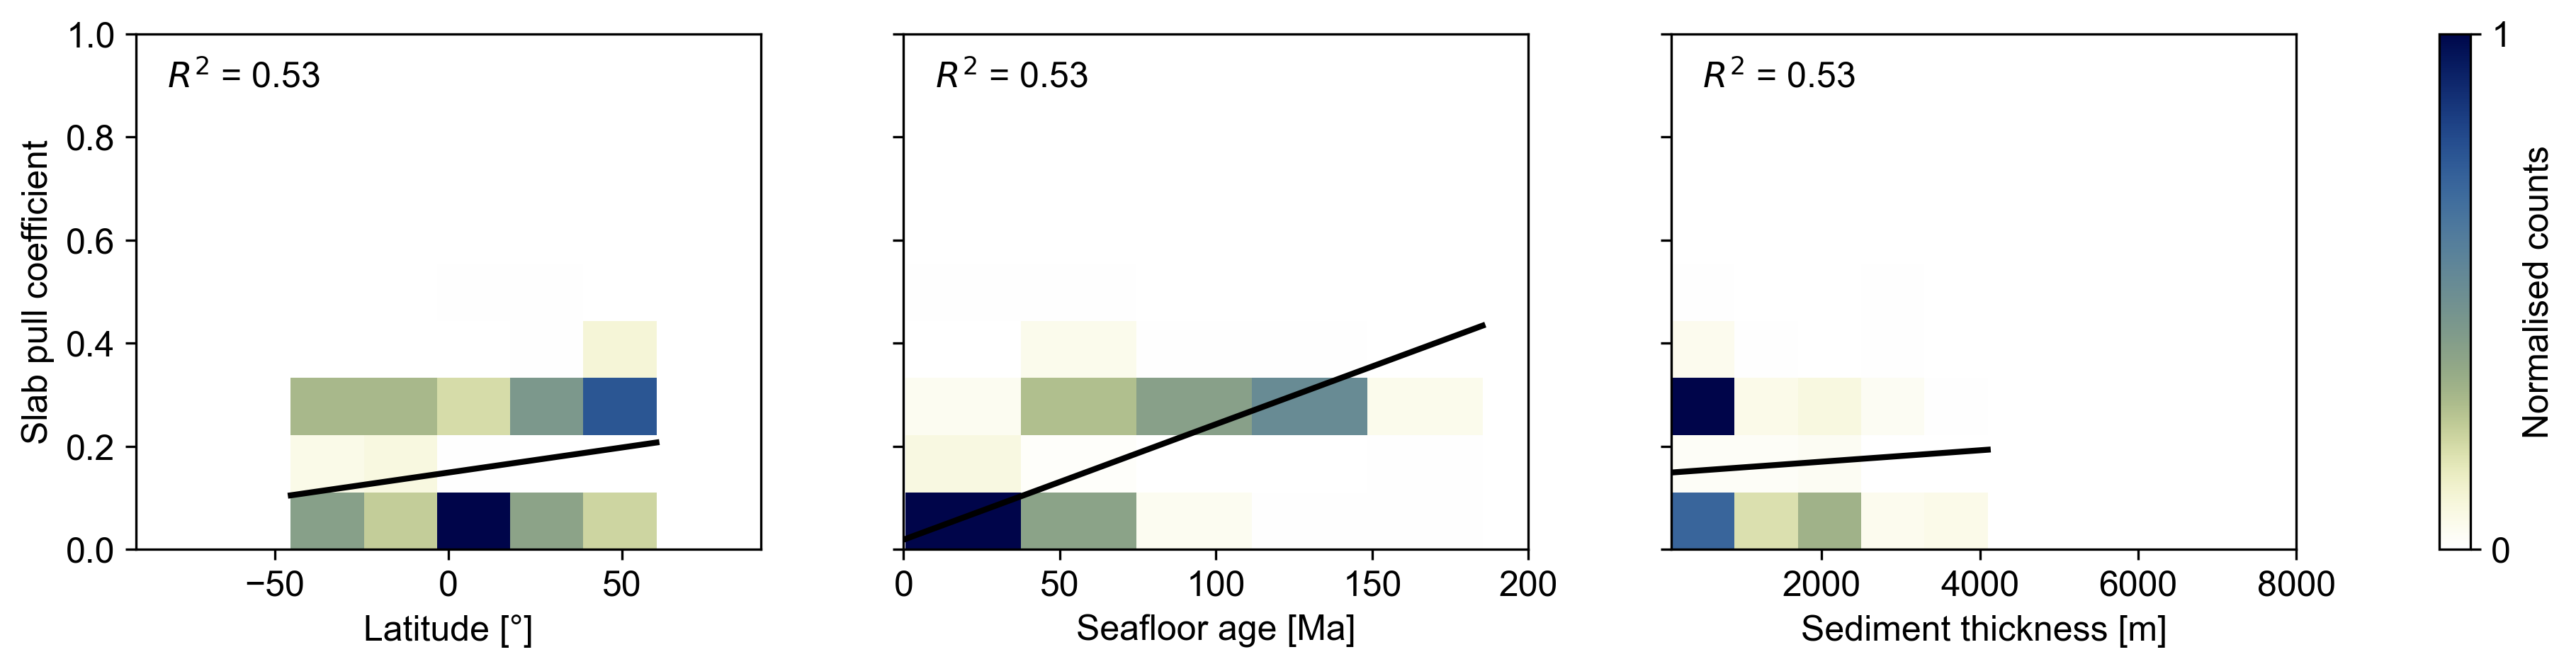

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Set up the figure and gridspec
fig = plt.figure(figsize=(fig_width, fig_height_graphs / 2), dpi=300)
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.3)

# Create subplots
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
cax = fig.add_subplot(gs[3])  # Colorbar axis

# Create sorted x ranges for smooth lines
lat_sort = np.linspace(np.min(lat_data), np.max(lat_data), 200)
age_sort = np.linspace(np.min(age_data), np.max(age_data), 200)
sed_sort = np.linspace(np.min(sed_data), np.max(sed_data), 200)

# Hold other variables at their mean for predictions
age_mean = np.mean(age_data)
sed_mean = np.mean(sed_data)
lat_mean = np.mean(lat_data)

# Predict lines using fixed other values
lat_line = model_multi.predict(np.column_stack((lat_sort, np.full_like(lat_sort, age_mean), np.full_like(lat_sort, sed_mean))))
age_line = model_multi.predict(np.column_stack((np.full_like(age_sort, lat_mean), age_sort, np.full_like(age_sort, sed_mean))))
sed_line = model_multi.predict(np.column_stack((np.full_like(sed_sort, lat_mean), np.full_like(sed_sort, age_mean), sed_sort)))

# Plot 1: Latitude vs. Slab pull coefficient
h0 = ax0.hist2d(lat_data, coeff_data, bins=5, cmap="cmc.davos_r", cmin=1)
ax0.plot(lat_sort, lat_line, color="black", lw=2)
ax0.set_xlabel("Latitude [°]")
ax0.set_ylabel("Slab pull coefficient")
ax0.set_ylim(0, 1)
ax0.set_xlim(-90, 90)
ax0.text(0.05, 0.95, f"$R^2$ = {r_squared_multi:.2f}", transform=ax0.transAxes, fontsize=12, va='top')

# Plot 2: Seafloor age vs. Slab pull coefficient
h1 = ax1.hist2d(age_data, coeff_data, bins=5, cmap="cmc.davos_r", cmin=1)
ax1.plot(age_sort, age_line, color="black", lw=2)
ax1.set_xlabel("Seafloor age [Ma]")
ax1.set_ylim(0, 1)
ax1.set_yticklabels([])
ax1.set_xlim(0, 200)
ax1.text(0.05, 0.95, f"$R^2$ = {r_squared_multi:.2f}", transform=ax1.transAxes, fontsize=12, va='top')

# Plot 3: Sediment thickness vs. Slab pull coefficient
h2 = ax2.hist2d(sed_data, coeff_data, bins=5, cmap="cmc.davos_r", cmin=1)
ax2.plot(sed_sort, sed_line, color="black", lw=2)
ax2.set_xlabel("Sediment thickness [m]")
ax2.set_ylim(0, 1)
ax2.set_xlim(1e2, 8e3)
ax2.set_yticklabels([])
ax2.text(0.05, 0.95, f"$R^2$ = {r_squared_multi:.2f}", transform=ax2.transAxes, fontsize=12, va='top')

# Add a colorbar using the last hist2d
cb = plt.colorbar(h2[3], cax=cax)
cb.set_label("Normalised counts")
cax.set_yticks([h2[3].get_array().min(), h2[3].get_array().max()])
cax.set_yticklabels([0, 1])

plt.tight_layout()
plt.show()


In [ ]:
plot_M2016 = PlotReconstruction(M2016, coastline_file=os.path.join(data_dir, "gplates_files", "M2016_coastlines.gpml"))

NameError: name 'h' is not defined

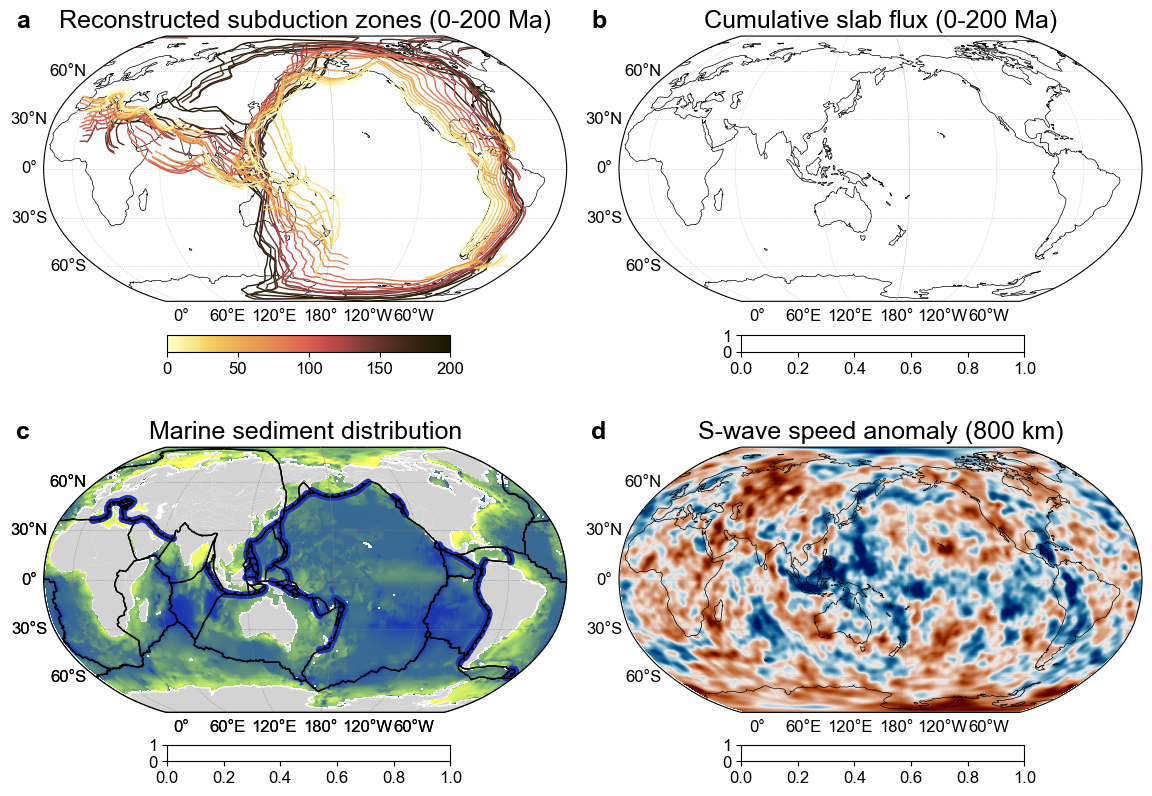

In [ ]:
fig = plt.figure(figsize=(fig_width, 11.3*cm2in*2))
gs = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.5)

plot_titles = ["Reconstructed subduction zones (0-200 Ma)", "Cumulative slab flux (0-200 Ma)", "Marine sediment distribution", "P-wave speed anomaly (1700 km)"]

reconstruction_ages = np.arange(0, 201, 10)
colours = plt.get_cmap("cmc.lajolla")(np.linspace(0, 1, len(reconstruction_ages)))
gplot = gplately.PlotTopologies(plot_M2016.reconstruction)

# Plot slab pull constant along trenches for each case
m = 0
for i in range(2):
    for j in range(2):
        ax = plt.subplot(gs[i, j], projection=projection)
        gl = plot_M2016.plot_basemap(ax)

        if m != 2:
            ax.coastlines(lw=0.5)

        ax.set_title(plot_titles[m], fontsize=title_fontsize)

        if m == 0:
            ax.imshow(np.ones_like(globsed.z), extent=[-180, 180, 90, -90], transform=ccrs.PlateCarree(), cmap="cmc.grayC", vmin=0, vmax=1)
            for k, age in enumerate(np.flip(reconstruction_ages)):
                gplot.update_time(age)
                trenches = gplot.plot_trenches(ax, lw=1, color=colours[k])

        if m == 1:
            h = ax.hist2d(
                lons, lats, bins=[72, 36], cmap="cmc.devon_r",
                weights=fluxes, transform=ccrs.PlateCarree(), norm=mcolors.LogNorm(vmin=1e16, vmax=1e18)
            )

        if m == 2:
            thicknesses = plot_M2016.plot_sediment_map(ax, 0, "ref", vmin=1e1)
            
        if m == 3:
            vp = ax.imshow(reveal.sel(depth=1700, method="nearest").vp_anomaly, extent=[-180, 180, 90, -90], transform=ccrs.PlateCarree(), cmap="cmc.vik_r", vmin=-1, vmax=1)

        ax.annotate(annotations[m], xy=(-0.053, 1.03), xycoords="axes fraction", fontweight="bold", fontsize=title_fontsize) 
        ax.set_global()

        m += 1

# Create a ScalarMappable for the colourbar
norm = Normalize(vmin=reconstruction_ages[0], vmax=reconstruction_ages[-1])
sm = cm.ScalarMappable(cmap="cmc.lajolla_r", norm=norm)
sm.set_array([])

# Create new grids for the colourbars
cax1 = fig.add_axes([0.212, 0.52, 0.2, 0.02*(10.5/11.3)])
cax2 = fig.add_axes([0.617, 0.52, 0.2, 0.02*(10.5/11.3)])
cax3 = fig.add_axes([0.212, 0.06, 0.2, 0.02*(10.5/11.3)])
cax4 = fig.add_axes([0.617, 0.06, 0.2, 0.02*(10.5/11.3)])

# # Create a colorbar below the subplots
cbar1 = plt.colorbar(sm, cax=cax1, orientation="horizontal")
cbar2 = plt.colorbar(h[3], cax=cax2, orientation="horizontal", extend="both", extendfrac=7.5e-2)
cbar3 = plt.colorbar(thicknesses[0], cax=cax3, orientation="horizontal", extend="both", extendfrac=7.5e-2)
cbar4 = plt.colorbar(vp, cax=cax4, orientation="horizontal", extend="both", extendfrac=7.5e-2)

# # Set colorbar label
cbar1.set_label("Reconstruction age [Ma]", labelpad=5)
cbar2.set_label("Log10(Slab flux [m$^3$])", labelpad=1.5)
cbar2.set_ticklabels([16, 17, 18, 19])
cbar3.set_label("Log10(Sediment thickness [m])", labelpad=5)
cbar4.set_label("dV [%]", labelpad=5)

# fig.savefig(os.path.join(figs_dir, f"M2016_subduction_REVEAL_mantle.png"), bbox_inches="tight", dpi=300)